In [1]:
from bs4 import BeautifulSoup as BS
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

import datetime

In [2]:
class WebScrapingToDF(object):
    def __init__(self, url):
        self._url = url
    
    def start(self, table_class="sortable wikitable"):
        """
            1. make initial request
            2. turn the request into soup object
            3. get table
            4. from table get columns and rows
            5. return pandas dataframe of data obtained
        """
        url_html = self._make_request()
        soup = BS(url_html, 'html.parser')
        
        table = WebScrapingToDF._get_table(soup, table_class=table_class)
        
        columns = WebScrapingToDF._get_headers(table)
        rows = WebScrapingToDF._get_rows(table)
        
        return pd.DataFrame(data=rows, columns=columns)
    
    def _make_request(self):
        request = urllib.request.Request(self._url)
        result = urllib.request.urlopen(request)
        return result.read()
    
    @staticmethod
    def _get_table(soup, table_class):
        table_html = soup.find_all('table', class_=table_class)
        return table_html[0]
    
    @staticmethod
    def _get_headers(table):
        table_headers = table.find_all("th")
        return [th.text for th in table_headers]
    
    @staticmethod
    def _get_rows(table):
        rows = []
        for tr in table.find_all("tr")[1:]:
            row_data = [td.text for td in tr.find_all("td")]
            rows.append(row_data)
            
        return rows
    

# We are using data from multiple resources. Here is all the links we used to gather this info!!! Results are all dataframes :D 

In [3]:
# Gather earthquakes info
earthquakes_scraping = WebScrapingToDF(url="https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900")
earthquakes = earthquakes_scraping.start()

In [4]:
# Gather volcano info
volcanoes_scraping = WebScrapingToDF(url="http://volcano.oregonstate.edu/volcano_table")
volcanoes = volcanoes_scraping.start(table_class="views-table cols-6")

In [5]:
# Gather vents info
vents_scraping = WebScrapingToDF(url="http://vents-data.interridge.org/ventfields_list_all")
vents = vents_scraping.start(table_class="views-table cols-8")

In [6]:
class CleanData(object):
    def __init__(self, df):
        self._df = df
        
    def clean_col_by_regex(self, regex, column):
        self._df[column] = self._df[column].str.replace(regex, "")
        
    def nan_to_float32(self, columns, value=0, inplace=True):    
        for col in columns:        
            self._df[col].fillna(value=value, inplace=inplace)
            self._df[col] = pd.to_numeric(self._df[col], downcast='float')
            
    def strip_columns(self, columns):
        for column in columns:
            self._df[column] = self._df[column].str.strip()      

## Cleaning the Earthquake Data

In [7]:
class CleanEarthquakes(CleanData):
    def __init__(self, df):
        super(CleanEarthquakes, self).__init__(df)
        
    def clean_cols_by_extract(self, columns, regex):
        for col in columns:
            self._df[col] = self._df[col].str.extract(regex, expand=True)
        
    def convert_nan_lat_lng(self, is_nan):
        """There are son lat/lng values in the dataframe that didn't exist on the wiki page, so we looked up the coords
            and assigned them to their appropriate location

            First index is LNG, second is LAT
        """
        for loc, coords in is_nan.items():
            self._df.iloc[loc, self._df.columns.get_loc('lng')] = coords[0]
            self._df.iloc[loc, self._df.columns.get_loc('lat')] = coords[1]

        assert self._df[self._df["lat"].isnull()].empty == True
        assert self._df[self._df["lng"].isnull()].empty == True
        
    def convert_values_in_row_by_index(self, index, **kwargs):
        """There is a unique case where the lat/lng as well as depth values are '?' or '??'"""
        for key, value in kwargs.items():
            self._df.iloc[index, self._df.columns.get_loc(key)] = value    
            
    def get_mean_deaths(self, column):
        """There can potentially be multiple values within the Other Source Deaths column. So, this is grabbing the 
            values and determining the mean
        """
        means = []
        for row in self._df[column]:
            if isinstance(row, str):
                int_list = row.strip().split(" ")
                total = 0
                total = sum(list(map(int, map(float, int_list))))

                mean = total / len(int_list)
                means.append(mean)
            else:
                means.append(row)

        self._df[column] = means
        
    def assign_mag_units_and_values(self):
        Mag = self._df['Mag'].str.split(" ")
        # print(Mag)
        values = [row[0] for row in Mag]

        units = [self._return_empty(row) for row in Mag]

        #print(units)
        self._df['Mag_Value'] = values
        self._df['Mag_Units'] = units
        
    def _return_empty(self, row):
        if len(row) < 2:
            return ''

        val= row [1]
        if val =="Mb":
            val = "mb"
        return val

In [8]:
# rename columns
earthquakes.columns = ["UTC", "Country", "lat", "lng", "Depth_km", "Mag", "Secondary_Effects", "PDE_Shaking_Deaths", "PDE_Deaths", "Utsu_Deaths", "EM-DAT_Deaths", "Other_Deaths"]

In [9]:
clean_earthquakes = CleanEarthquakes(earthquakes)

clean_earthquakes.clean_col_by_regex(regex=r"(\[\d+\]|\(.*\)|\*|\+|\,)", column="Other_Deaths")
clean_earthquakes.clean_col_by_regex("(\s\(.*)", column="Country")

is_nan = {439: [69.13, 41.16], 1319: [90.302, 29.759], 1320: [67.484, 30.569], 1323: [101.086, 25.619], 1324: [138.276, 34.778], 1325: [107.328, -7.778], 1326: [-171.87, -15.53], 1327: [99.97, 0.71], 1330: [40.03, 38.79], 1331: [-72.13, -34.301], 1332: [96.629, 33.165], 1333: [172.7012, -43.5834], 1334: [97.994, 24.71], 1336: [99.949, 20.705]}
clean_earthquakes.convert_nan_lat_lng(is_nan)

"""There is a unique case where the lat/lng as well as depth values are '?' or '??'"""
question_index = earthquakes[earthquakes["lat"] == "?"].index
clean_earthquakes.convert_values_in_row_by_index(question_index, lat=21.4, lng=42.1, Depth_km=6)

"""There are some bad characters in this column, so this regex just grabs the int"""
clean_earthquakes.clean_cols_by_extract(columns=['EM-DAT_Deaths'], regex='(\d+\.\d*)')

"""We want to extract the units and values from the magnitude column. The types of units in theis column
    represent different measurements, and so can't be compared overall.
"""
clean_earthquakes.assign_mag_units_and_values()

"""Transforms the column in the dataframe to a float32 column, rather than the object type. 
    Also fills all NaN values to 0.
"""
columns_to_convert = ['PDE_Deaths', 'PDE_Shaking_Deaths', 'Utsu_Deaths', 'EM-DAT_Deaths', 'Mag_Value', 'lat', 'lng', 'Depth_km']
clean_earthquakes.nan_to_float32(columns=columns_to_convert)

In [10]:
# Create the apropriate datetime columns with padding for javascript visuals
earthquakes["UTC"] = pd.to_datetime(earthquakes["UTC"])
earthquakes["Year"] = pd.DatetimeIndex(earthquakes["UTC"]).year
earthquakes["Month"] = pd.DatetimeIndex(earthquakes["UTC"]).month.map("{:02}".format)
earthquakes["Day"] = pd.DatetimeIndex(earthquakes["UTC"]).day.map("{:02}".format)

In [11]:
# Creating a new column 'deaths' that is the max of these four columns
subdf = earthquakes[["PDE_Deaths", "Utsu_Deaths", "EM-DAT_Deaths", "Other_Deaths"]]
earthquakes["Max_Deaths"] = subdf.max(axis = 1)

In [12]:
# Import plates and countries geojson to plot
plates_gdf = gpd.read_file("MR_Data/PB2002_plates.json")
countries_gdf = gpd.read_file("MR_Data/countries.geojson")

## magnitude

Categories:
1. local magnitude (ML), commonly referred to as "Richter magnitude"

The magnitude is a number that characterizes the relative size of an earthquake. Magnitude is based on measurement of the maximum motion recorded by a seismograph. Several scales have been defined, but the most commonly used are (1) local magnitude (ML), commonly referred to as "Richter magnitude", (2) surface-wave magnitude (Ms), (3) body-wave magnitude (Mb), and (4) moment magnitude (Mw). Scales `1-3` have limited range and applicability and do not satisfactorily measure the size of the largest earthquakes. The moment magnitude (Mw) scale, based on the concept of seismic moment, is uniformly applicable to all sizes of earthquakes but is more difficult to compute than the other types. All magnitude scales should yield approximately the same value for any given earthquake.

Where the details of how a magnitude has been determined are unknown catalogs will specify the scale as unknown (variously Unk, Ukn, or UK). In such cases the magnitude is considered generic and approximate.

In Japan, for shallow (depth < 60 km) earthquakes within 600 km, the Japanese Meteorological Agency calculates a magnitude labeled MJMA, MJMA, or MJ. (These should not be confused with moment magnitudes JMA calculates, which are labeled Mw(JMA) or M(JMA).) The magnitudes are based (as typical with local scales) on the maximum amplitude of the ground motion; they agree "rather well" with the seismic moment magnitude Mw in the range of 4.5 to 7.5, but underestimate larger magnitudes.

In [13]:
earthquakes['Mag_Units'].value_counts()

Mw      822
Muk     201
mb      145
Ms      122
ML       31
MJMA      8
Md        5
Lg        4
          2
Name: Mag_Units, dtype: int64

In [14]:
Death_top5 = earthquakes.sort_values('Max_Deaths',ascending=False).head(5)

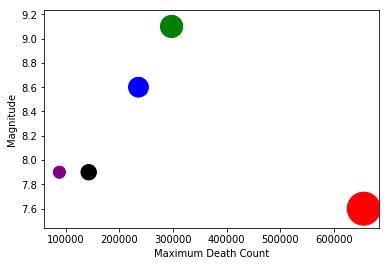

In [15]:
# Base size of dots based on frequency
np_death = np.array(Death_top5['Max_Deaths'])
np_death = np_death / 600

plt.scatter(Death_top5['Max_Deaths'], Death_top5['Mag_Value'], s=np_death, c=['red', 'green', 'blue', 'black', 'purple'], label='Country')

plt.xlabel('Maximum Death Count')
plt.ylabel('Magnitude')

plt.show()

In [16]:
Death_top5[['Country', 'Mag_Value', 'Mag_Units', 'Max_Deaths']]

Country  Mag_Value Mag_Units  Max_Deaths
583       China        7.6        Mw    655237.0
1238  Indonesia        9.1        Mw    297200.0
102       China        8.6        Ms    235502.0
116       Japan        7.9       Muk    142807.0
1308      China        7.9        Mw     88287.0

## 1976 Tangshan Earthquake
There is an obvious outlier in this data. China is really skewing our dataset. 

On further investigation, we saw that in 1976, this Tangshan Earthquake death count was overly reported at approximately 655,000 deaths, but this number has since been stated to be around 240,000 to 255,000. 
You can check out the link to this data [here](https://en.wikipedia.org/wiki/1976_Tangshan_earthquake).

With this being noted, we are changing the values to the more accurate values.

In [17]:
earthquakes.loc[583, 'Max_Deaths'] = 255000.0

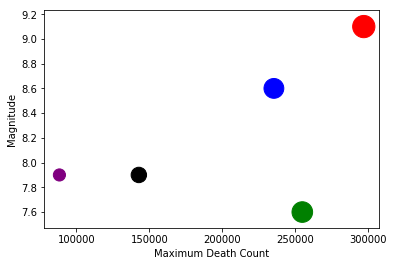

In [18]:
Death_top5 = earthquakes.sort_values('Max_Deaths',ascending=False).head(5)

np_death = np.array(Death_top5['Max_Deaths'])
np_death = np_death / 600

plt.scatter(Death_top5['Max_Deaths'], Death_top5['Mag_Value'], s=np_death, c=['red', 'green', 'blue', 'black', 'purple'], label='Country')

plt.xlabel('Maximum Death Count')
plt.ylabel('Magnitude')

plt.show()

With this being shown, I think we are able to determine that Magnitude has correlation with death count.

In [19]:
def create_gdf(df):
    geometry = [Point(xy) for xy in zip(df.lng, df.lat)]
        
    crs = {"init": "epsg:4326"} 
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [20]:
earthquakes_Mag_top5 = earthquakes.sort_values('Mag_Value',ascending=False).head(5)
earthquakes_Death_top5 = earthquakes.sort_values('Max_Deaths',ascending=False).head(5)
earthquakes_Depth_km_top5 = earthquakes.sort_values('Depth_km',ascending=False).head(5)

earthquakes_Mag_top5_sum = earthquakes_Mag_top5['Mag_Value'].sum()
earthquakes_Death_top5_sum = earthquakes_Death_top5['Max_Deaths'].sum()
earthquakes_Depth_km_top5_sum = earthquakes_Depth_km_top5['Depth_km'].sum()

earthquakes_Mag_top5['norm'] = earthquakes_Mag_top5['Mag_Value'] / earthquakes_Mag_top5_sum
earthquakes_Death_top5['norm'] = earthquakes_Death_top5['Max_Deaths'] / earthquakes_Death_top5_sum
earthquakes_Depth_km_top5['norm'] = earthquakes_Depth_km_top5['Depth_km'] / earthquakes_Depth_km_top5_sum

earthquakes_Mag_top5['cat'] = 'Mag'
earthquakes_Death_top5['cat'] = 'Death'
earthquakes_Depth_km_top5['cat'] = 'Depth'

In [21]:
earthquakes_Mag_top5

UTC             Country        lat         lng  \
396  1960-05-22 19:11:00               Chile -38.235001  -73.046997   
416  1964-03-28 03:36:00       United States  61.016998 -147.647995   
1238 2004-12-26 00:58:00           Indonesia   3.287000   95.972000   
1335 2011-03-11 14:46:00               Japan  38.321999  142.369003   
332  1952-11-04 16:58:00  Russian Federation  52.755001  160.057007   

       Depth_km      Mag Secondary_Effects  PDE_Shaking_Deaths  PDE_Deaths  \
396   35.000000  9.5 Muk                 T                 NaN         NaN   
416    6.600000  9.2 Muk                 T                 NaN         NaN   
1238  30.000000   9.1 Mw               T,L                 NaN    297200.0   
1335  24.400000   9.0 Mw                 T                 NaN         NaN   
332   22.200001  9.0 Muk                 T                 NaN         NaN   

      Utsu_Deaths  EM-DAT_Deaths          Other_Deaths  Mag_Value Mag_Units  \
396        5700.0            0.0                              9.5       Muk   
416         131.0            0.0                              9.2       Muk   
1238          NaN            0.0  231000 283000 227898        9.1        Mw   
1335          NaN            0.0                 15894        9.0        Mw   
332           NaN            0.0                              9.0       Muk   

      Year Month Day  Max_Deaths      norm  cat  
396   1960    05  22      5700.0  0.207424  Mag  
416   1964    03  28       131.0  0.200873  Mag  
1238  2004    12  26    297200.0  0.198690  Mag  
1335  2011    03  11         0.0  0.196507  Mag  
332   1952    11  04         0.0  0.196507  Mag

In [22]:
earthquakes_mag_death_depth = pd.concat([earthquakes_Mag_top5, earthquakes_Death_top5, earthquakes_Depth_km_top5], ignore_index=False)
earthquakes_mag_death_depth = earthquakes_mag_death_depth[['lng', 'lat', 'Country', 'Mag_Units', 'Mag_Value', 'Depth_km', 'Max_Deaths', 'norm', 'cat']].sort_index()

earthquakes_mag_death_depth_gdf = create_gdf(df=earthquakes_mag_death_depth)

In [23]:
earthquakes_mag_death_depth_gdf.sort_values('cat')

lng        lat             Country Mag_Units  Mag_Value  \
102   105.317001  36.601002               China        Ms        8.6   
116   139.084000  35.404999               Japan       Muk        7.9   
583   117.888000  39.605000               China        Mw        7.6   
1238   95.972000   3.287000           Indonesia        Mw        9.1   
1308  103.321999  31.002001               China        Mw        7.9   
501   -72.563004  -1.486000            Colombia       Muk        8.0   
738   138.871002  29.372000               Japan        Mw        7.4   
953   137.925995  32.029999               Japan        Mw        6.9   
970   -67.512001 -13.860000             Bolivia        Mw        8.2   
1242  123.337997   5.321000         Philippines        Mw        7.1   
332   160.057007  52.755001  Russian Federation       Muk        9.0   
396   -73.046997 -38.235001               Chile       Muk        9.5   
416  -147.647995  61.016998       United States       Muk        9.2   
1238   95.972000   3.287000           Indonesia        Mw        9.1   
1335  142.369003  38.321999               Japan        Mw        9.0   

        Depth_km  Max_Deaths      norm    cat  \
102    25.000000    235502.0  0.231157  Death   
116    35.000000    142807.0  0.140172  Death   
583    16.700001    255000.0  0.250295  Death   
1238   30.000000    297200.0  0.291717  Death   
1308   19.000000     88287.0  0.086658  Death   
501   644.599976         1.0  0.247182  Depth   
738   459.100006         1.0  0.176049  Depth   
953   351.000000         1.0  0.134596  Depth   
970   631.000000        10.0  0.241966  Depth   
1242  522.099976         2.0  0.200207  Depth   
332    22.200001         0.0  0.196507    Mag   
396    35.000000      5700.0  0.207424    Mag   
416     6.600000       131.0  0.200873    Mag   
1238   30.000000    297200.0  0.198690    Mag   
1335   24.400000         0.0  0.196507    Mag   

                                           geometry  
102     POINT (105.3170013427734 36.60100173950195)  
116     POINT (139.0839996337891 35.40499877929688)  
583     POINT (117.8880004882812 39.60499954223633)  
1238    POINT (95.97200012207031 3.286999940872192)  
1308    POINT (103.3219985961914 31.00200080871582)  
501   POINT (-72.56300354003906 -1.485999941825867)  
738     POINT (138.8710021972656 29.37199974060059)  
953     POINT (137.9259948730469 32.02999877929688)  
970   POINT (-67.51200103759766 -13.85999965667725)  
1242    POINT (123.3379974365234 5.321000099182129)  
332     POINT (160.0570068359375 52.75500106811523)  
396    POINT (-73.0469970703125 -38.23500061035156)  
416    POINT (-147.6479949951172 61.01699829101562)  
1238    POINT (95.97200012207031 3.286999940872192)  
1335    POINT (142.3690032958984 38.32199859619141)

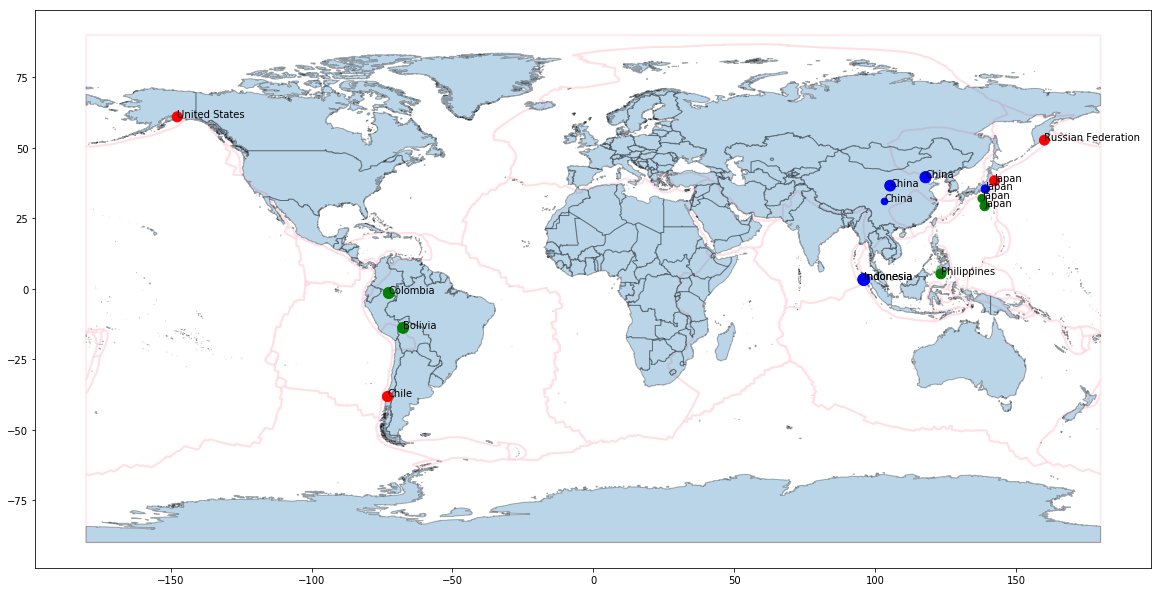

In [24]:
norm_size = np.array(earthquakes_mag_death_depth_gdf['norm'])
norm_size = norm_size * 500

fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
plates_gdf.plot(ax=ax, color='white', edgecolor='pink', alpha=0.3, lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

colors = {'Mag':'red', 'Death':'blue', 'Depth':'green', 'G':'black'}
earthquakes_mag_death_depth_gdf.plot(
    ax=ax, 
    markersize=norm_size, 
    color=earthquakes_mag_death_depth_gdf['cat'].apply(lambda x: colors[x]),
    label=earthquakes_mag_death_depth_gdf['cat'].apply(lambda x: x)
)

for row in earthquakes_mag_death_depth_gdf.iterrows():
    plt.text(row[1].lng, row[1].lat, row[1].Country)

[Text(0,0,'China'),
 Text(0,0,'Indonesia'),
 Text(0,0,'Turkey'),
 Text(0,0,'Iran'),
 Text(0,0,'Japan'),
 Text(0,0,'Peru'),
 Text(0,0,'Taiwan'),
 Text(0,0,'Mexico'),
 Text(0,0,'Chile'),
 Text(0,0,'Greece'),
 Text(0,0,'Philippines'),
 Text(0,0,'Italy'),
 Text(0,0,'United States'),
 Text(0,0,'Afghanistan'),
 Text(0,0,'Pakistan'),
 Text(0,0,'India'),
 Text(0,0,'Colombia'),
 Text(0,0,'Algeria'),
 Text(0,0,'Ecuador'),
 Text(0,0,'Papua New Guinea'),
 Text(0,0,'Guatemala'),
 Text(0,0,'South Africa'),
 Text(0,0,'Russian Federation'),
 Text(0,0,'Argentina'),
 Text(0,0,'Burma')]

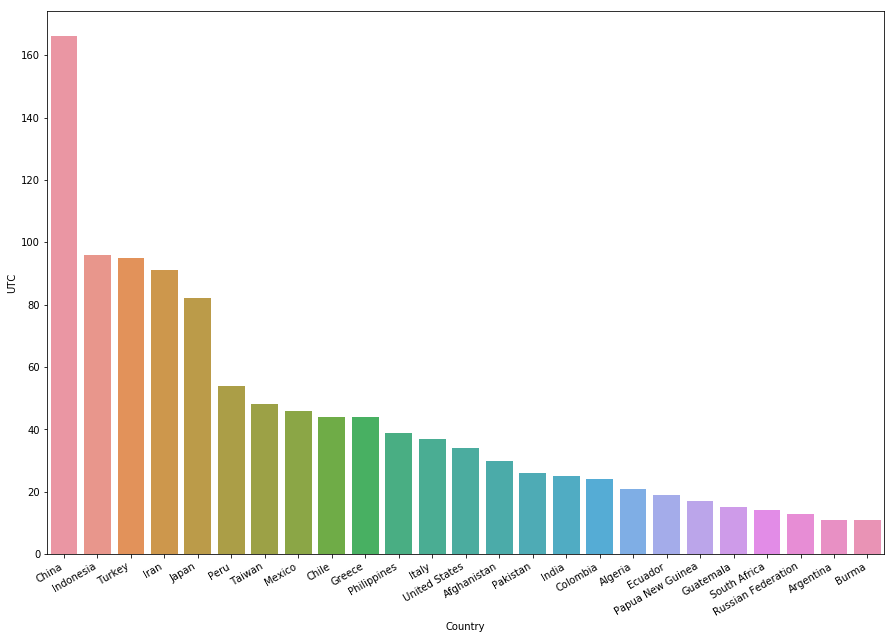

In [25]:
quakes_country_25 = earthquakes.groupby("Country").agg(len).reset_index().nlargest(25, columns="UTC")

f, ax = plt.subplots(figsize=(15, 10))
#plt.ylabel('Number of Quakes')
quake_count = sns.barplot(x='Country', y='UTC', data=quakes_country_25)
quake_count.set_xticklabels(quake_count.get_xticklabels(), rotation=30, ha="right")

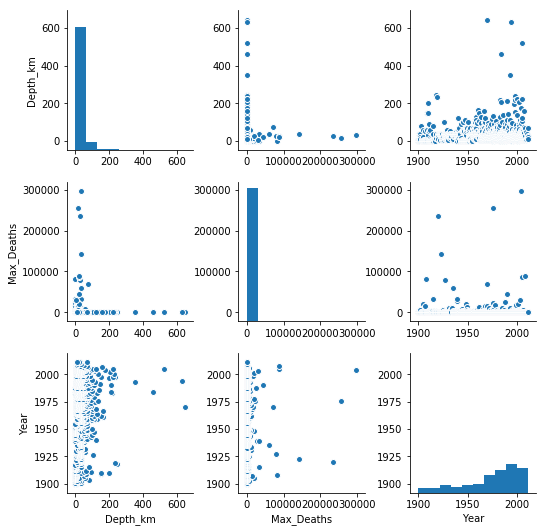

In [26]:
"""Trying to find any correlation between these columns. Most interesting find is between Depth and Mag"""
earthquakes_cont = earthquakes[["Depth_km", "Mag", "Max_Deaths", "Year"]]
earthquakes_cont = earthquakes_cont.replace("?", np.nan)
earthquakes_cont = earthquakes_cont.dropna()

sns.pairplot(earthquakes_cont, dropna=True)

In [27]:
# Total deaths by country
occurrence_death = earthquakes[['Country', 'Max_Deaths']].groupby(['Country']).agg(['sum', 'count'])
occurrence_death.columns=['Total Deaths', 'Frequency of Earthquakes']

EQ_Casualities = occurrence_death.sort_values(['Frequency of Earthquakes'], ascending=False)
EQ_Casualities.head()

Total Deaths  Frequency of Earthquakes
Country                                          
China          738151.0                       166
Indonesia      342112.0                        96
Turkey          90836.0                        95
Iran           152664.0                        91
Japan          166997.0                        82

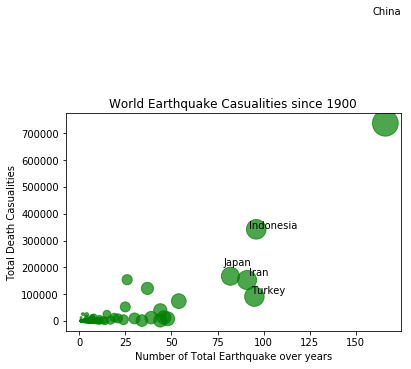

In [28]:
# Base size of dots based on frequency
np_death = np.array(EQ_Casualities['Frequency of Earthquakes'])
np_death = np_death*4

# Find correlation between Frequency and Total Deaths
plt.scatter(EQ_Casualities['Frequency of Earthquakes'], EQ_Casualities['Total Deaths'], s=np_death, color='green', alpha=0.7)

# Hard code some labels
plt.text(159, 1143382.0, 'China')
plt.text(93, 103304.0, 'Turkey')
plt.text(92, 167960.0, 'Iran')
plt.text(92, 343574.0, 'Indonesia')
plt.text(78, 205148.0, 'Japan')

plt.xlabel('Number of Total Earthquake over years')
plt.ylabel('Total Death Casualities')

plt.title('World Earthquake Casualities since 1900')

plt.show()

In [29]:
earthquakes.drop("UTC", inplace=True, axis=1)
earthquakes.to_json("JSONs_for_TP/earthquakes_original.json")

## Cleaning the Volcano Data

In [30]:
class CleanVolcanoes(CleanData):
    def __init__(self, df):
        super(CleanVolcanoes, self).__init__(df)
        
    def replace_all_rows_by_regex(self, regex):
        self._df.replace(to_replace=regex, value="", regex=True, inplace=True)     

In [31]:
volcanoes.columns = ["Name", "Country", "Type", "lat", "lng", "Elevation"]

In [32]:
clean_volcanos = CleanVolcanoes(volcanoes)

# Replacing new lines and spaces with empty strings
clean_volcanos.replace_all_rows_by_regex(regex="(\n|\n\s)")

# remove extra whitespace from these columns
clean_volcanos.strip_columns(columns=['lat', 'lng', 'Elevation'])

# Convert lat and lng vals to numeric
columns_to_convert = ['lat', 'lng', 'Elevation']
clean_volcanos.nan_to_float32(columns=columns_to_convert)


## Cleaning the Vents Data

In [33]:
class CleanVents(CleanData):
    def __init__(self, df):
        super(CleanVents, self).__init__(df)
        

In [34]:
# Renaming columns
vents.columns = ["Name", "Activity", "Tectonic Setting", "Region", "lat", "lng", "Depth", "Year&Discovered"]

In [35]:
# Some basic cleaning of the rows
vents = vents.replace(to_replace="(\n|\n\s)", value="", regex=True)

clean_vents = CleanVents(df=vents)

# Strip extra whitespace from these columns
clean_vents.strip_columns(columns=['lat', 'lng', 'Year&Discovered', 'Depth'])

# Turn appropriate columns to numeric
clean_vents.nan_to_float32(["lat", "lng", "Depth"])

## Create GeoPandas DFs to Graph Later On

In [36]:
earthquakes_gdf = create_gdf(df=earthquakes)
volcanoes_gdf = create_gdf(df=volcanoes)
vents_gdf = create_gdf(df=vents)

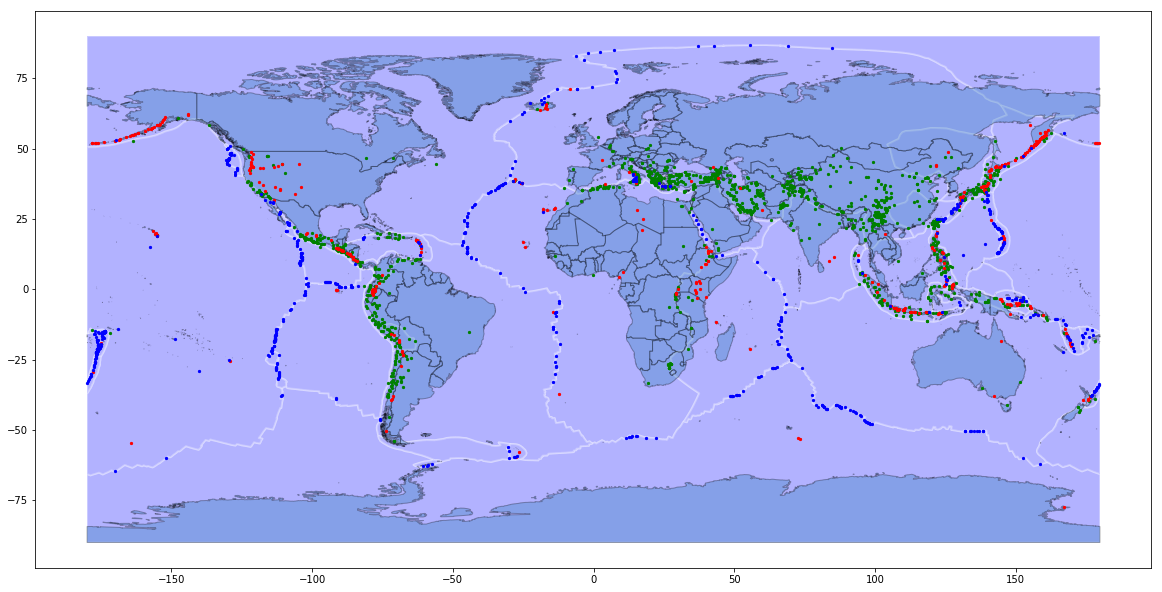

In [37]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha=0.3, lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

# all points (earthquakes, volcanoes, and vents)
earthquakes_gdf.plot(ax=ax, markersize=5, color="green")
volcanoes_gdf.plot(ax=ax, markersize=5, color="red")
vents_gdf.plot(ax=ax, markersize=5, color="blue")

In [38]:
# Now that we have our data plotted out, we want to categorize the earthquakes based on location. 
# How close are they to the plates, and which plates are they closest to?
boundaries_gdf = gpd.read_file("MR_Data/PB2002_steps.json")

In [39]:
class ClosestPointLogic(object):
    def __init__(self, from_df, to_df, categories, extra_column_name):
        self._from_df = from_df
        self._to_df = to_df
        self._categories = categories
        self._extra_column_name = extra_column_name
    
    # We are wanting to grab the geometry columns per type of volcano
    def get_geometries_from_gdf(self, column):
        geometry_types = list()
        for df_type in self._categories:
            if df_type == 'None':
                df_type_geometry = self._to_df[self._to_df[column].str.contains("")].geometry
            else: 
                df_type_geometry = self._to_df[self._to_df[column].str.contains(df_type)].geometry

            geometry_types.append(df_type_geometry)
            
        # Add on the geometry from the overall df to compare against        
        geometry_types.extend([self._to_df.geometry]) 
        
        return geometry_types
    
    def calculate_nearest(self, to_column, dist_df):
        # Determine closest point based on category
        conditions = list()
        for col in self._categories:
            if not col == self._extra_column_name:
                dist_bool = (dist_df[self._extra_column_name] == dist_df[col])
                conditions.append(dist_bool)

        dist_df[to_column] = np.select(conditions, self._categories, default=np.nan)
        
        return dist_df
    
    def create_total_dist_df(self, series_geometry_list):
        total_dist_list = self._calculate_total_dist_list(series_geometry_list)
        
        dist_pd = pd.DataFrame(total_dist_list)
        dist_pd = dist_pd.transpose()

        dist_pd.columns = self._categories + [self._extra_column_name]

        return pd.concat([self._from_df, dist_pd], axis=1)
    
    def _calculate_total_dist_list(self, series_geometry_list):
        total_dist_list = []

        for geoseries in series_geometry_list:
            dist_list = self._quake_distance(geoseries)
            total_dist_list.append(dist_list)
            
        return total_dist_list
    
    def _quake_distance(self, geoseries):
        dist_list = []
        for quake in self._from_df.geometry:
            print(quake)
            dist = np.min([quake.distance(series) for series in geoseries if series])
            print(dist)
            dist_list.append(dist)

        return dist_list

In [40]:
vol_types = ["Stratovolcano", "Caldera", "Shield", "Complex Volcano", "Submarine", "Volcanic Field", "Cinder Cone", "Dome",
        "Fissure vents", "Somma Volcano", "Maar", "Pyroclastic Cone", "Tuff Ring", "Plug", "None"]

volcanoes_to_earthquake_logic = ClosestPointLogic(
    from_df=earthquakes_gdf,
    to_df=volcanoes_gdf,
    categories=vol_types,
    extra_column_name='vol'
)

In [41]:
vol_series_geometry_list = volcanoes_to_earthquake_logic.get_geometries_from_gdf(column='Type')

quake_vol_dist = volcanoes_to_earthquake_logic.create_total_dist_df(
    series_geometry_list=vol_series_geometry_list
)

quake_vol_dist = volcanoes_to_earthquake_logic.calculate_nearest(
    to_column='closest_vol',
    dist_df=quake_vol_dist
)

POINT (141.1000061035156 38.70000076293945)
1.10163363025
POINT (43.09999847412109 40.29999923706055)
1.3416407865
POINT (-66 11)
5.35362463221
POINT (100.0999984741211 26)
7.38312448136
POINT (28.70000076293945 43.40000152587891)
6.98195685493
POINT (142.5 40.5)
1.82187269177
POINT (173 -43)
3.86005428375
POINT (141.3000030517578 40.5)
0.763682013248
POINT (48.59999847412109 40.70000076293945)
4.41474726782
POINT (33.59999847412109 40.70000076293945)
7.63974393086
POINT (-91 14)
0.48507825162
POINT (129.6000061035156 43.20000076293945)
7.88156355242
POINT (77 40)
20.8086520467
POINT (138 -35)
27.9575550797
POINT (72.30000305175781 40.79999923706055)
17.751902871
POINT (35.29999923706055 32.20000076293945)
9.24833415835
POINT (42.65000152587891 39.13999938964844)
1.74243909076
POINT (42.70000076293945 40.90000152587891)
1.99999923706
POINT (22.96999931335449 36.36000061035156)
1.50880869981
POINT (58.20000076293945 35.20000076293945)
6.13600862601
POINT (120.5 23.5)
3.38541143917
POINT

0.813937467917
POINT (-77.59999847412109 1.100000023841858)
0.259418649736
POINT (103.2649993896484 35.63299942016602)
16.1269070285
POINT (103.4970016479492 28.73299980163574)
9.22381972879
POINT (103.6839981079102 28.67499923706055)
9.1652224319
POINT (105.6999969482422 34.20000076293945)
14.8365255896
POINT (103 26.60000038146973)
7.1170573673
POINT (94.75900268554688 5.296000003814697)
7.42928055348
POINT (-95.87799835205078 18.52300071716309)
2.78668204892
POINT (115.1529998779297 35.25199890136719)
10.7066381576
POINT (121.5469970703125 14.31799983978271)
1.09577566579
POINT (-98.28700256347656 17.43099975585938)
1.62351851009
POINT (34.01499938964844 39.43899917602539)
7.42346375755
POINT (119.5250015258789 -0.3659999966621399)
5.41023290568
POINT (142.0449981689453 37.00899887084961)
1.86499431458
POINT (-72.19999694824219 -36.20000076293945)
1.94509381066
POINT (159.2339935302734 -9.295000076293945)
0.608799765198
POINT (139.968994140625 39.8390007019043)
0.80020134212
POINT (

16.016942462
POINT (80.85399627685547 29.55400085449219)
18.6673909187
POINT (68.62899780273438 30.05100059509277)
8.86939719038
POINT (78.89199829101562 28.61599922180176)
18.3835441582
POINT (41.58000183105469 39.1609992980957)
2.7728881095
POINT (100.088996887207 27.45700073242188)
8.69613818785
POINT (-78.68399810791016 -10.80700016021729)
8.45188001247
POINT (21.17600059509277 38.87400054931641)
3.92173057115
POINT (-70.65499877929688 -25.50200080871582)
2.65498231853
POINT (-74.79900360107422 2.888999938964844)
1.69910428219
POINT (112.9459991455078 -9.168000221252441)
1.05832001088
POINT (116.6009979248047 38.51599884033203)
7.27397186444
POINT (96.23200225830078 5.084000110626221)
6.06071276324
POINT (21.29100036621094 39.55199813842773)
4.24853987705
POINT (30.73999977111816 40.63199996948242)
5.39945941493
POINT (40.40800094604492 39.50199890136719)
3.89703161835
POINT (-73.072998046875 6.788000106811523)
2.94132985538
POINT (-67.30999755859375 10.55500030517578)
6.7288549701

POINT (29.01499938964844 37.74300003051758)
2.18413186878
POINT (104.181999206543 32.48099899291992)
12.9831679092
POINT (13.18099975585938 46.3390007019043)
7.81692010451
POINT (13.20600032806396 46.31399917602539)
7.78630622709
POINT (13.08699989318848 46.35400009155273)
7.85628494585
POINT (-78.73200225830078 -0.7260000109672546)
0.0695710977659
POINT (139.9909973144531 -4.474999904632568)
4.71533836164
POINT (101.0210037231445 27.55400085449219)
8.45344556904
POINT (59.18000030517578 33.81999969482422)
5.87748210948
POINT (44.03099822998047 39.08200073242188)
0.674007106439
POINT (-68.89600372314453 -20.47200012207031)
2.06114951482
POINT (26.67700004577637 -27.97900009155273)
26.5838111568
POINT (101.0240020751953 27.33600044250488)
8.24533194174
POINT (91.01399993896484 38.18500137329102)
22.53146632
POINT (26.70199966430664 45.7760009765625)
9.19741133721
POINT (122.2850036621094 16.7549991607666)
2.1201079406
POINT (56.36299896240234 27.58300018310547)
3.66082851207
POINT (40.0

3.24109656518
POINT (17.82900047302246 42.9739990234375)
4.93609192022
POINT (121.6019973754883 32.60400009155273)
8.5937701823
POINT (-80.80000305175781 46.58000183105469)
32.6959562172
POINT (-69.37100219726562 17.98100090026855)
6.15102559174
POINT (-69.23300170898438 18.03899955749512)
6.01691917334
POINT (137.4660034179688 35.80099868774414)
0.436963804928
POINT (-115.9869995117188 47.45999908447266)
5.16407225358
POINT (42.24100112915039 40.89199829101562)
2.37914508076
POINT (42.44699859619141 40.71099853515625)
2.11085950989
POINT (92.86399841308594 24.68400001525879)
11.9357405724
POINT (-68.59300231933594 -33.10900115966797)
5.39610629478
POINT (52.97200012207031 28.35199928283691)
7.03680934652
POINT (-71.76200103759766 -33.13199996948242)
4.75499498278
POINT (14.26299953460693 41.63100051879883)
2.99467672704
POINT (-71.68000030517578 -32.71200180053711)
5.16324626536
POINT (123.5120010375977 7.776000022888184)
0.990917747434
POINT (-63.59999847412109 -18.5669994354248)
5.4

7.91739523433
POINT (44.01100158691406 42.40599822998047)
1.81397525541
POINT (120.3160018920898 15.16499996185303)
0.0487930006115
POINT (-89.63300323486328 13.40799999237061)
0.402011665789
POINT (-118.0110015869141 34.23699951171875)
8.30156503063
POINT (124.5869979858398 -8.145999908447266)
1.08411078599
POINT (20.98100090026855 45.39300155639648)
8.76949647437
POINT (-71.72100067138672 -15.70699977874756)
0.148220870416
POINT (44.06100082397461 36.59799957275391)
3.11119456566
POINT (-90.93199920654297 14.60400009155273)
0.116276490194
POINT (78.77500152587891 30.72500038146973)
18.9717239432
POINT (-77.35600280761719 4.552000045776367)
2.06386834709
POINT (44.06800079345703 13.88700008392334)
2.28608833798
POINT (49.58200073242188 36.82600021362305)
2.67547349462
POINT (27.43000030517578 -26.42000007629395)
24.9664255279
POINT (50.75799942016602 31.60499954223633)
4.55048819647
POINT (-84.302001953125 10.22799968719482)
0.0772514790642
POINT (39.6510009765625 39.72700119018555)
4

2.21809796821
POINT (-71.24400329589844 -32.32699966430664)
5.52349460143
POINT (-80.31300354003906 -0.593999981880188)
1.60436258072
POINT (77.29799652099609 39.57199859619141)
20.8118196021
POINT (15.97500038146973 40)
1.43154577632
POINT (112.3399963378906 -8.177000045776367)
0.248815261135
POINT (20.0939998626709 44.20299911499023)
7.29067924088
POINT (53.64199829101562 27.79100036621094)
6.36143588967
POINT (100.9550018310547 27.26300048828125)
8.19824633089
POINT (124.818000793457 -1.939000010490417)
3.05026961104
POINT (71 36.51800155639648)
13.9124530732
POINT (-75.65899658203125 4.443999767303467)
0.560209762506
POINT (69.16500091552734 34.32300186157227)
11.1345226356
POINT (46.90900039672852 43.26200103759766)
4.41528402346
POINT (57.20700073242188 28.27099990844727)
2.80611579573
POINT (79.4010009765625 30.47500038146973)
19.5582326855
POINT (-72.51799774169922 -16.60199928283691)
1.05920077486
POINT (26.67900085449219 -27.95299911499023)
26.5577386053
POINT (51.90700149536

19.0600005916
POINT (100.9940032958984 38.37099838256836)
19.0429284636
POINT (103.8649978637695 34.7130012512207)
15.2049749323
POINT (103.9739990234375 27.46199989318848)
7.95987512623
POINT (125.4160003662109 12.11299991607666)
1.48453034909
POINT (80.54599761962891 42.8849983215332)
25.3712670795
POINT (-121.0749969482422 35.62900161743164)
5.88754429154
POINT (-82.84200286865234 8.369000434875488)
2.2976300974
POINT (58.26800155639648 28.95000076293945)
1.97542908206
POINT (115.7580032348633 -8.348999977111816)
0.248164344265
POINT (135.5970001220703 -3.66100001335144)
9.03305795406
POINT (73.17800140380859 34.75099945068359)
14.8066105028
POINT (73.16899871826172 34.77199935913086)
14.8081903878
POINT (100.5479965209961 -0.515999972820282)
0.482411693433
POINT (29.44599914550781 -3.359999895095825)
1.85000423245
POINT (-3.984999895095825 35.18399810791016)
14.4205539323
POINT (-4.079999923706055 35.22499847412109)
14.3570743535
POINT (-4.177999973297119 35.24599838256836)
14.2816

22.4623079029
POINT (-102.5 17.5)
9.27105374764
POINT (130 28)
2.80717003314
POINT (20.5 38)
8.64597591719
POINT (-20 64)
2.7028316391
POINT (97 21)
18.5106809576
POINT (27 40.5)
7.7637174126
POINT (-99.91999816894531 19.82999992370605)
7.13140429318
POINT (126.5 4.5)
3.39166660628
POINT (25.5 43.5)
10.2793633688
POINT (-74 -17)
22.1095312091
POINT (-72.90000152587891 -14.19999980926514)
23.2183429966
POINT (102 24.5)
21.6995396003
POINT (130.6000061035156 31.60000038146973)
0.860351143984
POINT (140.3999938964844 39.5)
1.10059384495
POINT (15.19999980926514 37.70000076293945)
4.7424561317
POINT (137 -2)
10.0689312607
POINT (102.5 -4.5)
7.97466522681
POINT (91.5 43.5)
40.8382172386
POINT (32.5 37.5)
2.28589177265
POINT (13.5 42)
0.844334384215
POINT (143.6000061035156 42.09999847412109)
1.34405994341
POINT (-115.5 32.79999923706055)
12.1042015718
POINT (-89 14)
0.333766767116
POINT (91.5 29.5)
27.9000955366
POINT (120.5 23.89999961853027)
9.91211835852
POINT (121 24)
10.0000050021
POIN

20.9419778246
POINT (92.47799682617188 12.14900016784668)
11.4853704013
POINT (43.29999923706055 39.5)
8.82911542183
POINT (102.3000030517578 31.70000076293945)
25.7411330963
POINT (39.40000152587891 39.70000076293945)
5.00912296103
POINT (132 32)
1.25159929429
POINT (120.390998840332 23.25099945068359)
9.27037165742
POINT (99.14499664306641 21.07600021362305)
18.4986823438
POINT (100.3000030517578 23.10000038146973)
20.572586672
POINT (-79.90200042724609 0.01200000010430813)
11.6542648479
POINT (-90.91300201416016 13.77999973297119)
1.37532978032
POINT (-74.91999816894531 -14.97500038146973)
22.1328511134
POINT (20.39999961853027 41.70000076293945)
7.70005824585
POINT (36.45000076293945 40.67100143432617)
2.85291245701
POINT (30.5 40.79999923706055)
4.59709708825
POINT (-101.5 17.75)
8.27918739975
POINT (-72 -30.75)
8.23400408617
POINT (30.5 40.59999847412109)
4.50347629331
POINT (110 -9.5)
16.4528191278
POINT (134 35.25)
3.73751139253
POINT (34 41)
2.48501548471
POINT (121.5 22.89999

POINT (125.9970016479492 12.53499984741211)
5.21692556415
POINT (-92.81800079345703 16.89999961853027)
0.61753301514
POINT (-155.0339965820312 19.45199966430664)
37.5591506165
POINT (40.5260009765625 38.59500122070312)
6.00605255622
POINT (21.7140007019043 38.5260009765625)
9.56649459841
POINT (-16.57799911499023 66.22599792480469)
0.535551347967
POINT (-89.14499664306641 15.29599952697754)
1.48933676607
POINT (-90.46900177001953 14.8120002746582)
1.33016832179
POINT (-76.89900207519531 19.86400032043457)
12.1623854019
POINT (-91.00599670410156 14.72500038146973)
1.70216623924
POINT (67.75800323486328 36.58700180053711)
33.2971036167
POINT (42.95399856567383 40.93899917602539)
8.76039283515
POINT (43.68899917602539 39.80099868774414)
9.25126456308
POINT (112.2220001220703 40.22999954223633)
20.2676846239
POINT (-79.56400299072266 0.8500000238418579)
12.0479291803
POINT (42.875 40.93500137329102)
8.68327416876
POINT (13.26599979400635 46.3849983215332)
4.68928242037
POINT (-74.418998718

10.0722446846
POINT (140.3220062255859 35.42100143432617)
5.08428885953
POINT (26.69400024414062 -26.90500068664551)
37.9966190814
POINT (91.57900238037109 24.71299934387207)
23.290484245
POINT (-118.0500030517578 34.08000183105469)
9.74592855478
POINT (121.0849990844727 12.35499954223633)
1.64774140507
POINT (121.6790008544922 23.98600006103516)
10.0097413723
POINT (95.12599945068359 25.10499954223633)
22.8275106275
POINT (160.9329986572266 -10.31999969482422)
9.82142716372
POINT (51.58499908447266 29.94400024414062)
19.121245897
POINT (51.65499877929688 29.88599967956543)
19.2098939025
POINT (86.61799621582031 26.76300048828125)
27.0915226123
POINT (18.48900032043457 49.88600158691406)
10.0016446783
POINT (146.2259979248047 -6.061999797821045)
4.01693700962
POINT (-90.50099945068359 13.90799999237061)
0.962196558297
POINT (99.68099975585938 22.90900039672852)
20.3468046066
POINT (99.41100311279297 23.18600082397461)
20.6141901512
POINT (44.11800003051758 40.91899871826172)
9.88126470

POINT (54.80099868774414 39.53200149536133)
20.3038010399
POINT (31.26499938964844 38.45100021362305)
3.2571755909
POINT (-88.70200347900391 13.07600021362305)
0.688432668814
POINT (70.28700256347656 23.40200042724609)
33.9027294006
POINT (-89.00099945068359 13.60000038146973)
0.085447704438
POINT (-89.10600280761719 13.78699970245361)
0.129710775103
POINT (101.0790023803711 29.45899963378906)
25.2077053858
POINT (-122.5810012817383 47.09000015258789)
4.17664390357
POINT (132.5399932861328 34.10800170898438)
1.88490440786
POINT (99.05100250244141 24.80599975585938)
22.2270985474
POINT (100.9010009765625 27.61899948120117)
24.2702480993
POINT (69.32399749755859 35.10499954223633)
34.9760551807
POINT (6.869999885559082 49.14699935913086)
9.43402275778
POINT (-73.50499725341797 -16.38500022888184)
22.6720642471
POINT (-71.93099975585938 -17.5319995880127)
21.4419410866
POINT (11.23400020599365 46.72299957275391)
5.20376826363
POINT (-69.23400115966797 -19.5580005645752)
19.5461388725
POIN

17.9446430682
POINT (125 6)
29.0742623912
POINT (104 29)
28.1426782115
POINT (-74 4)
16.2638840861
POINT (117.2429962158203 23.54000091552734)
18.0622621188
POINT (-117.4400024414062 33.8120002746582)
10.6081378991
POINT (123.5630035400391 5.652999877929688)
29.9456645651
POINT (150.2530059814453 46.8120002746582)
12.0324282907
POINT (-67.63099670410156 18.47299957275391)
20.6721581939
POINT (152.6289978027344 -5.47700023651123)
1.28097281397
POINT (122.0800018310547 23.8129997253418)
14.3123183383
POINT (-97.08000183105469 19.27000045776367)
11.4102845217
POINT (44.09999847412109 42)
19.5205005087
POINT (10.30000019073486 44.29999923706055)
17.0417119608
POINT (105.3170013427734 36.60100173950195)
26.3668456127
POINT (-68.40000152587891 -32.70000076293945)
39.4658257768
POINT (39.44499969482422 15.60999965667725)
2.36962544874
POINT (127.2570037841797 7.896999835968018)
26.955171802
POINT (139.8000030517578 35.20000076293945)
1.65420481776
POINT (122.0400009155273 24.50600051879883)
1

21.3793790502
POINT (122.8779983520508 7.386000156402588)
28.4823174397
POINT (101.6129989624023 29.98100090026855)
30.3255989247
POINT (74.63999938964844 39.81600189208984)
42.8859212561
POINT (-71.59999847412109 -29.89999961853027)
35.3484291573
POINT (23 39.5)
3.92045771671
POINT (27.20000076293945 37.59999847412109)
2.16333002468
POINT (29.60000038146973 32.20000076293945)
5.93969804093
POINT (-84.5 10)
4.27129749963
POINT (101.6999969482422 26.60000038146973)
30.9260495611
POINT (19.29999923706055 47.5)
12.6657005641
POINT (30.5 40)
6.24259504571
POINT (35.5 35.5)
10.1400202392
POINT (67.47899627685547 35.04199981689453)
34.3055963441
POINT (26.02599906921387 36.61700057983398)
0.662543509268
POINT (95.802001953125 21.9689998626709)
37.9278666101
POINT (70 23)
30.7709269948
POINT (140.3099975585938 35.64199829101562)
1.48521128734
POINT (54.40499877929688 27.28300094604492)
19.3662457662
POINT (8.899999618530273 36.20000076293945)
16.5012120859
POINT (121.5169982910156 23.91699981

POINT (119.2799987792969 31.53300094604492)
12.672239891
POINT (138.77099609375 34.56999969482422)
2.31166383013
POINT (104.0070037841797 28.19499969482422)
28.3041835396
POINT (-63.42900085449219 10.50899982452393)
24.2571812365
POINT (-77.63099670410156 7.736999988555908)
11.2282724534
POINT (139.9010009765625 36.01599884033203)
0.941325422887
POINT (-81.01899719238281 -5.881999969482422)
11.4784413922
POINT (-77.52300262451172 -12.25399971008301)
18.0190283116
POINT (72.89800262451172 35.0260009765625)
38.6753775079
POINT (78.4739990234375 32.37300109863281)
42.1817555409
POINT (122.6460037231445 40.66699981689453)
10.8722603615
POINT (106.6340026855469 -6.77400016784668)
39.8061279632
POINT (56.2239990234375 27.47699928283691)
20.8222386044
POINT (-71.39299774169922 -29.90999984741211)
35.4714690568
POINT (-69.66600036621094 10.0649995803833)
18.129874801
POINT (94.59799957275391 21.45199966430664)
39.2351729965
POINT (5.241000175476074 36.31999969482422)
20.1591581877
POINT (78.60

31.8772932699
POINT (-77.66600036621094 0.03999999910593033)
13.4622093305
POINT (-77.78700256347656 0.0820000022649765)
13.3428272076
POINT (20.20599937438965 51.36899948120117)
15.8445112996
POINT (131.7850036621094 32.05099868774414)
2.45597873039
POINT (98.90499877929688 2.404999971389771)
45.8154180464
POINT (10.68000030517578 44.80899810791016)
16.9525692242
POINT (125.3239974975586 8.267000198364258)
26.973293507
POINT (125.4789962768555 8.02299976348877)
27.175325257
POINT (48.28499984741211 34.05899810791016)
21.8197799962
POINT (121.3529968261719 17.32399940490723)
20.0004048852
POINT (115.5660018920898 25.00200080871582)
18.6360210262
POINT (-70.00499725341797 -19.09199905395508)
28.1800224521
POINT (-70.90899658203125 -17.89999961853027)
26.7148957813
POINT (-78.03099822998047 -1.008999943733215)
13.1018044621
POINT (-118.1350021362305 34.06100082397461)
10.1427472225
POINT (-77.96099853515625 -8.166000366210938)
15.2645043612
POINT (-118.1370010375977 34.02000045776367)
10

29.4134114108
POINT (69.20999908447266 36.05099868774414)
36.2886666777
POINT (69.24800109863281 36.05300140380859)
36.3197684199
POINT (122.1419982910156 24.29999923706055)
13.9102094645
POINT (147.5449981689453 -6.230999946594238)
5.05119139418
POINT (69.29599761962891 35.98799896240234)
36.317399641
POINT (-76.5780029296875 -12.42800045013428)
18.8526330602
POINT (21.53300094604492 42.41999816894531)
7.15500093051
POINT (47.4010009765625 34.60200119018555)
22.0451228582
POINT (44.85699844360352 41.76699829101562)
20.1836433172
POINT (121.8679962158203 24.66799926757812)
13.8340252586
POINT (33.73799896240234 -2.918999910354614)
3.13793918358
POINT (49.02000045776367 35.59700012207031)
23.5178738943
POINT (13.72799968719482 38.33499908447266)
11.8313058429
POINT (142.9400024414062 -3.26200008392334)
9.31469602612
POINT (93.09300231933594 13.01299953460693)
44.0962643478
POINT (134.2299957275391 -1.700000047683716)
18.1528467059
POINT (29.01300048828125 -1.962000012397766)
0.582814853

7.62856077367
POINT (-115.5 32.79999923706055)
30.3799992804
POINT (-89 14)
1.64450454671
POINT (91.5 29.5)
25.0598688183
POINT (120.5 23.89999961853027)
13.0291976169
POINT (121 24)
12.7687722922
POINT (120.9000015258789 21.89999961853027)
11.0054523341
POINT (116 -7)
6.10327627656
POINT (114 31)
16.3847940284
POINT (125 6)
5.16980805788
POINT (104 29)
25.2815541307
POINT (-74 4)
13.2208657829
POINT (117.2429962158203 23.54000091552734)
14.0579417402
POINT (-117.4400024414062 33.8120002746582)
32.5412405648
POINT (123.5630035400391 5.652999877929688)
5.8460627625
POINT (150.2530059814453 46.8120002746582)
15.6792415571
POINT (-67.63099670410156 18.47299957275391)
19.2695685069
POINT (152.6289978027344 -5.47700023651123)
4.75033711798
POINT (122.0800018310547 23.8129997253418)
12.1430121293
POINT (-97.08000183105469 19.27000045776367)
7.52915651448
POINT (44.09999847412109 42)
40.3881577559
POINT (10.30000019073486 44.29999923706055)
49.5220477716
POINT (105.3170013427734 36.6010017395

POINT (104 27.39999961853027)
23.7619225152
POINT (-106.5 22)
17.0133014543
POINT (83.5 41)
38.3027030116
POINT (-122.5 47.25)
45.2509099589
POINT (-73.5 -38)
17.0420565893
POINT (70.5 39)
42.7705167726
POINT (26.29999923706055 38.59999847412109)
37.7055858399
POINT (-78.25 -1.5)
14.2131556596
POINT (40.59999847412109 39.5)
37.3977712588
POINT (-71 -54)
32.3280319972
POINT (-71 -54)
32.3280319972
POINT (121 18)
7.38241153012
POINT (-72 -13.5)
6.00461299389
POINT (112 -6.25)
2.30488464547
POINT (-68 10.5)
17.3231431726
POINT (96.5 28.5)
23.5906126791
POINT (-67.5 -23.5)
1.86324816041
POINT (-96.80000305175781 16.10000038146973)
5.81227220971
POINT (33.40000152587891 40.79999923706055)
38.6103513946
POINT (121.5 23.75)
12.587456126
POINT (122.5 23)
11.6726175299
POINT (41.70000076293945 39.90000152587891)
37.9285305629
POINT (143 42.5)
7.56246601958
POINT (-68.46700286865234 -31.58099937438965)
9.79362966901
POINT (135.8000030517578 34.40000152587891)
3.38420990371
POINT (-119.0459976196

0.451424716773
POINT (-76.89900207519531 19.86400032043457)
12.3501564394
POINT (-91.00599670410156 14.72500038146973)
0.234271731356
POINT (67.75800323486328 36.58700180053711)
42.6590149502
POINT (42.95399856567383 40.93899917602539)
39.143103404
POINT (43.68899917602539 39.80099868774414)
38.1510867637
POINT (112.2220001220703 40.22999954223633)
19.5512990672
POINT (-79.56400299072266 0.8500000238418579)
11.5209329509
POINT (42.875 40.93500137329102)
39.1263512874
POINT (13.26599979400635 46.3849983215332)
49.8477732134
POINT (-74.41899871826172 -11.65999984741211)
8.87755654174
POINT (63.42800140380859 40.37300109863281)
46.5766374215
POINT (98.93000030517578 24.50099945068359)
19.76277454
POINT (98.61000061035156 24.58099937438965)
19.802692161
POINT (140.1089935302734 -4.531000137329102)
7.05984307512
POINT (40.4630012512207 38.32699966430664)
36.216839878
POINT (114.7740020751953 -8.227999687194824)
4.98123128391
POINT (98.66699981689453 24.76799964904785)
19.9950422782
POINT (1

1.0173982875
POINT (100.7519989013672 26.32799911499023)
21.8697222368
POINT (26.79999923706055 -28.02799987792969)
31.8818757523
POINT (-76.59400177001953 18.05200004577637)
11.3269733622
POINT (144.1940002441406 43.02199935913086)
8.71388362886
POINT (144.1410064697266 43.02399826049805)
8.68105638977
POINT (101.4150009155273 25.82600021362305)
21.5252476643
POINT (86.14399719238281 42.20000076293945)
38.6561619768
POINT (-178.1620025634766 -14.40900039672852)
91.6760107379
POINT (87.35600280761719 29.00900077819824)
25.7156470721
POINT (21.52599906921387 37.61299896240234)
38.3655800855
POINT (-76.51300048828125 -11.7209997177124)
10.2382815588
POINT (50.82600021362305 30.17900085449219)
31.294687778
POINT (-83.61199951171875 9.824000358581543)
1.98224613772
POINT (139.2469940185547 42.89199829101562)
6.53147029172
POINT (-71.20600128173828 6.380000114440918)
14.7989002803
POINT (31.70100021362305 15.40100002288818)
13.9577834663
POINT (-92.64600372314453 14.75800037384033)
1.466841

POINT (16 39)
41.9033928695
POINT (24 40)
49.9377044286
POINT (-81.5 1)
22.8497183474
POINT (120.4000015258789 23.60000038146973)
24.8344350982
POINT (120.4000015258789 23.60000038146973)
24.8344350982
POINT (-123 38)
10.592568722
POINT (-72 -33)
46.4695559472
POINT (85 43.5)
64.3139732089
POINT (94.5 2)
53.7826847549
POINT (-76.69999694824219 18.20000076293945)
16.1744716519
POINT (-100 17)
38.6468581522
POINT (123 14)
22.9463994386
POINT (69 38)
78.0359988191
POINT (121.0999984741211 23)
24.0686791123
POINT (15.5 38)
41.3819324315
POINT (26.89999961853027 38.59999847412109)
52.7894712148
POINT (50 33)
76.0193018818
POINT (38 40)
63.9250678537
POINT (122.5 25)
22.9908078217
POINT (-8.800000190734863 38.90000152587891)
17.1294008287
POINT (103 24.39999961853027)
42.2180197753
POINT (101 -2)
49.4094848782
POINT (5.400000095367432 43.70000076293945)
31.8692387952
POINT (136.3000030517578 35.40000152587891)
17.3382025837
POINT (68 30)
77.6234314526
POINT (131.1000061035156 32.299999237060

POINT (122.0780029296875 16.38400077819824)
23.3041499269
POINT (-97.77100372314453 16.49399948120117)
36.3736044983
POINT (119.6900024414062 0.05799999833106995)
32.5073293517
POINT (58.95999908447266 34.04499816894531)
84.9144471184
POINT (58.21200180053711 34.07199859619141)
84.1659753631
POINT (32.45199966430664 41.77099990844727)
58.4809314212
POINT (-62.71900177001953 10.73099994659424)
1.90420794635
POINT (-92.66000366210938 15.55099964141846)
31.1898968016
POINT (79.23899841308594 41.42599868774414)
69.0630704997
POINT (118.7990036010742 -3.178999900817871)
35.284244472
POINT (-10.56799983978271 35.92300033569336)
15.4035595225
POINT (28.46699905395508 38.53499984741211)
54.3550406358
POINT (41.21900177001953 11.93900012969971)
71.8384490502
POINT (33.93600082397461 27.51099967956543)
60.6608749595
POINT (119.4530029296875 38.42100143432617)
31.2764890386
POINT (111.8089981079102 21.61199951171875)
33.2423787997
POINT (137.0930023193359 35.7859992980957)
17.2947924211
POINT (19

27.5388130086
POINT (121.0589981079102 13.54300022125244)
24.9379630322
POINT (143.4299926757812 40.52299880981445)
11.8382485406
POINT (135.0249938964844 34.58000183105469)
17.3379863998
POINT (-72.93599700927734 5.044000148773193)
13.4256880208
POINT (-109.7850036621094 41.48799896240234)
20.701582959
POINT (-76.58899688720703 4.052000045776367)
17.0734306035
POINT (121.7060012817383 24.23299980163574)
23.6336164429
POINT (32.26900100708008 35.06000137329102)
58.2044483334
POINT (-77.30699920654297 1.281999945640564)
19.1533603491
POINT (-79.50900268554688 -2.132999897003174)
22.9698230364
POINT (21.7180004119873 40.14400100708008)
47.6659366027
POINT (125.0390014648438 -8.461999893188477)
32.9157255478
POINT (122.9440002441406 -8.288000106811523)
35.0136491923
POINT (142.822998046875 52.60400009155273)
11.2689592977
POINT (22.30900001525879 38.44400024414062)
48.1963897048
POINT (121.6790008544922 24.6200008392334)
23.7257056901
POINT (99.10299682617188 21.94799995422363)
45.9524133

43.4241253778
POINT (132.5 34.09999847412109)
15.9514527634
POINT (16 39)
41.4850913219
POINT (24 40)
40.5148466708
POINT (-81.5 1)
40.8600055053
POINT (120.4000015258789 23.60000038146973)
25.7630133356
POINT (120.4000015258789 23.60000038146973)
25.7630133356
POINT (-123 38)
3.9700012207
POINT (-72 -33)
74.8658139726
POINT (85 43.5)
41.4500064973
POINT (94.5 2)
56.4143872408
POINT (-76.69999694824219 18.20000076293945)
33.1472499437
POINT (-100 17)
17.7451408978
POINT (123 14)
34.8599039285
POINT (69 38)
54.5649410693
POINT (121.0999984741211 23)
26.2053220871
POINT (15.5 38)
40.7188261381
POINT (26.89999961853027 38.59999847412109)
38.7977149402
POINT (50 33)
38.6974520714
POINT (38 40)
40.8863400003
POINT (122.5 25)
23.9946426895
POINT (-8.800000190734863 38.90000152587891)
54.9425057628
POINT (103 24.39999961853027)
33.5558788431
POINT (101 -2)
56.5997620297
POINT (5.400000095367432 43.70000076293945)
50.1788687169
POINT (136.3000030517578 35.40000152587891)
16.7646890244
POINT (6

POINT (122.6460037231445 40.66699981689453)
8.77037632172
POINT (106.6340026855469 -6.77400016784668)
58.8157154891
POINT (56.2239990234375 27.47699928283691)
38.0957815248
POINT (-71.39299774169922 -29.90999984741211)
72.4146171912
POINT (-69.66600036621094 10.0649995803833)
43.3448129571
POINT (94.59799957275391 21.45199966430664)
41.6794984731
POINT (5.241000175476074 36.31999969482422)
43.9774148144
POINT (78.60500335693359 31.9370002746582)
50.3919069668
POINT (40.76800155639648 38.51499938964844)
40.0905614062
POINT (125.9970016479492 12.53499984741211)
36.1852104271
POINT (-92.81800079345703 16.89999961853027)
21.3542768909
POINT (-155.0339965820312 19.45199966430664)
40.5008169576
POINT (40.5260009765625 38.59500122070312)
40.1029048122
POINT (21.7140007019043 38.5260009765625)
39.4684904322
POINT (-16.57799911499023 66.22599792480469)
80.9848707436
POINT (-89.14499664306641 15.29599952697754)
24.9559291483
POINT (-90.46900177001953 14.8120002746582)
24.4533938026
POINT (-76.89

36.599533612
POINT (100.9550018310547 27.26300048828125)
33.0708353615
POINT (124.818000793457 -1.939000010490417)
50.6757300374
POINT (71 36.51800155639648)
55.017998069
POINT (-75.65899658203125 4.443999767303467)
42.1484291838
POINT (69.16500091552734 34.32300186157227)
52.189430231
POINT (46.90900039672852 43.26200103759766)
46.5527140527
POINT (57.20700073242188 28.27099990844727)
39.3492007608
POINT (79.4010009765625 30.47500038146973)
50.1552109158
POINT (-72.51799774169922 -16.60199928283691)
60.4262830549
POINT (26.67900085449219 -27.95299911499023)
28.0607939253
POINT (51.90700149536133 29.51899909973145)
36.8717911011
POINT (47.48300170898438 40.76699829101562)
44.4627517771
POINT (-97.44499969482422 18.38100051879883)
17.5459339649
POINT (-88.28500366210938 15.79100036621094)
25.1903431986
POINT (91.93299865722656 21.65800094604492)
43.6016411098
POINT (54.64799880981445 36.15700149536133)
43.8701971572
POINT (30.00300025939941 40.77299880981445)
40.8530831228
POINT (29.912

52.7462141914
POINT (22.66600036621094 41.33700180053711)
113.101358914
POINT (-85.69999694824219 13.19999980926514)
1.21494832027
POINT (46 39.20000076293945)
110.554166063
POINT (1.5 54.08000183105469)
97.5054075161
POINT (89.96499633789062 46.57099914550781)
66.1248297639
POINT (67.1719970703125 29.47299957275391)
91.2651382289
POINT (139.3809967041016 36.02099990844727)
22.0519135755
POINT (161.0160064697266 -10.93200016021729)
7.56136186305
POINT (131.9450073242188 32.00299835205078)
30.3511379285
POINT (-75.84999847412109 19.77000045776367)
13.0548868326
POINT (-71.9739990234375 8.14900016784668)
15.3581683938
POINT (115 31.39999961853027)
45.2245893891
POINT (126.1689987182617 0.257999986410141)
29.7190683038
POINT (-87.89399719238281 12.36400032043457)
1.20289341019
POINT (-104.1460037231445 19.45700073242188)
1.94648177617
POINT (-103.6320037841797 19.45199966430664)
1.43281108678
POINT (-104.3789978027344 19.02799987792969)
2.22953556579
POINT (23.73200035095215 40.3330001831

62.8358613583
POINT (117.8880004882812 39.60499954223633)
39.6236267662
POINT (118.359001159668 39.72299957275391)
39.1383603045
POINT (104.0879974365234 32.75299835205078)
54.8495720782
POINT (124.088996887207 6.291999816894531)
33.4881468866
POINT (122.9599990844727 7.258999824523926)
34.8981423004
POINT (29.01499938964844 37.74300003051758)
118.4342208
POINT (104.181999206543 32.48099899291992)
54.8496665664
POINT (13.18099975585938 46.3390007019043)
105.454325542
POINT (13.20600032806396 46.31399917602539)
105.46998927
POINT (13.08699989318848 46.35400009155273)
105.370114669
POINT (-78.73200225830078 -0.7260000109672546)
15.4492925964
POINT (139.9909973144531 -4.474999904632568)
15.2955645486
POINT (101.0210037231445 27.55400085449219)
59.5668386571
POINT (59.18000030517578 33.81999969482422)
98.2252368891
POINT (44.03099822998047 39.08200073242188)
112.524910043
POINT (-68.89600372314453 -20.47200012207031)
37.4805886014
POINT (26.67700004577637 -27.97900009155273)
120.389794394


POINT (70.28700256347656 23.40200042724609)
89.8809773994
POINT (-89.00099945068359 13.60000038146973)
2.54611721036
POINT (-89.10600280761719 13.78699970245361)
2.72389277521
POINT (101.0790023803711 29.45899963378906)
58.8035034497
POINT (-122.5810012817383 47.09000015258789)
15.8934754296
POINT (132.5399932861328 34.10800170898438)
28.6234965461
POINT (99.05100250244141 24.80599975585938)
62.4702002908
POINT (100.9010009765625 27.61899948120117)
59.6525400775
POINT (69.32399749755859 35.10499954223633)
88.0118058942
POINT (6.869999885559082 49.14699935913086)
100.48688478
POINT (-73.50499725341797 -16.38500022888184)
31.7652179026
POINT (-71.93099975585938 -17.5319995880127)
33.476036669
POINT (11.23400020599365 46.72299957275391)
103.738117983
POINT (-69.23400115966797 -19.5580005645752)
36.5159921647
POINT (-72.68000030517578 -14.34799957275391)
30.2970701424
POINT (100.5859985351562 26.28899955749512)
60.4647323563
POINT (-72.43499755859375 -15.35299968719482)
31.302347706
POINT 

113.431693542
POINT (70.5 39)
43.4225582096
POINT (26.29999923706055 38.59999847412109)
2.10487563393
POINT (-78.25 -1.5)
93.9791822119
POINT (40.59999847412109 39.5)
13.7542897206
POINT (-71 -54)
124.207926722
POINT (-71 -54)
124.207926722
POINT (121 18)
18.5003543186
POINT (-72 -13.5)
95.5752015931
POINT (112 -6.25)
44.0470818429
POINT (-68 10.5)
79.2554049761
POINT (96.5 28.5)
35.2555354045
POINT (-67.5 -23.5)
98.8217543605
POINT (-96.80000305175781 16.10000038146973)
71.2627767114
POINT (33.40000152587891 40.79999923706055)
7.4996356957
POINT (121.5 23.75)
13.7631984391
POINT (122.5 23)
13.6170167104
POINT (41.70000076293945 39.90000152587891)
14.9139720288
POINT (143 42.5)
14.79437366
POINT (-68.46700286865234 -31.58099937438965)
105.299427436
POINT (135.8000030517578 34.40000152587891)
4.51125224727
POINT (-119.0459976196289 34.94900131225586)
42.1681870935
POINT (91.64800262451172 30.79700088500977)
39.8594030435
POINT (-118.9169998168945 35.33300018310547)
42.052864654
POINT (3

15.305469892
POINT (144.1410064697266 43.02399826049805)
15.3486359163
POINT (101.4150009155273 25.82600021362305)
30.9267170095
POINT (86.14399719238281 42.20000076293945)
46.1561244291
POINT (-178.1620025634766 -14.40900039672852)
77.8044845923
POINT (87.35600280761719 29.00900077819824)
44.2804472293
POINT (21.52599906921387 37.61299896240234)
1.81401458926
POINT (-76.51300048828125 -11.7209997177124)
98.1015402495
POINT (50.82600021362305 30.17900085449219)
24.5593094604
POINT (-83.61199951171875 9.824000358581543)
85.6058846716
POINT (139.2469940185547 42.89199829101562)
12.3893520656
POINT (-71.20600128173828 6.380000114440918)
83.9907082074
POINT (31.70100021362305 15.40100002288818)
21.7525403264
POINT (-92.64600372314453 14.75800037384033)
75.3925177859
POINT (-122.0039978027344 42.30500030517578)
35.7556455566
POINT (76.47799682617188 18.05999946594238)
52.7311107675
POINT (137.9259948730469 32.02999877929688)
6.61517532246
POINT (146.1309967041016 -5.843999862670898)
41.7948

111.279878349
POINT (-64.38099670410156 9.49899959564209)
53.7770146271
POINT (57.69300079345703 37.95700073242188)
43.2740881572
POINT (37.90000152587891 40.20000076293945)
25.4366367694
POINT (-67.59799957275391 -34.76800155639648)
82.7994362706
POINT (172.2920074462891 -41.83100128173828)
171.566377947
POINT (58 37.5)
43.4707534611
POINT (-68.73699951171875 -23.03800010681152)
75.0713291689
POINT (-56.00799942016602 44.53900146484375)
41.5975966059
POINT (96.54299926757812 17.66500091552734)
81.6199697919
POINT (44.68500137329102 38.15200042724609)
30.8247339332
POINT (103 26.79999923706055)
87.4282358004
POINT (15.36699962615967 41.04999923706055)
13.0517374021
POINT (13.5 43.75)
15.8867523328
POINT (19.5 40.5)
13.1002442954
POINT (139.1029968261719 34.97700119018555)
123.719882434
POINT (19.60000038146973 40.29999923706055)
12.9402621655
POINT (96.4219970703125 17.97200012207031)
81.4615816456
POINT (120.5999984741211 23.20000076293945)
105.129634681
POINT (-66.30000305175781 -24.

POINT (-71.53500366210938 -34.13399887084961)
84.9321821499
POINT (102.8850021362305 25.89100074768066)
87.3304717105
POINT (120.8119964599609 16.54100036621094)
105.854058815
POINT (151.0559997558594 -5.60099983215332)
139.580706834
POINT (70.85700225830078 36.16500091552734)
55.8767771713
POINT (75.26399993896484 39.44699859619141)
60.7718161213
POINT (75.41500091552734 39.35599899291992)
60.9030874161
POINT (136.0930023193359 -4.064000129699707)
124.705588691
POINT (-102.379997253418 18.42000007629395)
88.9173360169
POINT (-101.6230010986328 17.83099937438965)
88.2334720404
POINT (69.80999755859375 40.33700180053711)
55.6155936488
POINT (6.846000194549561 36.38600158691406)
12.1081697165
POINT (15.06799983978271 37.6879997253418)
9.70151961108
POINT (-77.43699645996094 -9.51200008392334)
73.8647670986
POINT (-115.8000030517578 47.47000122070312)
98.0903095785
POINT (-71.75700378417969 -13.40200042724609)
71.2574647583
POINT (76.39700317382812 32.11800003051758)
60.9562614386
POINT (

POINT (121.0999984741211 23)
39.3966615786
POINT (15.5 38)
3.01617267837
POINT (26.89999961853027 38.59999847412109)
12.6660683835
POINT (50 33)
36.4194628395
POINT (38 40)
23.5842592657
POINT (122.5 25)
37.0723192254
POINT (-8.800000190734863 38.90000152587891)
23.3092109692
POINT (103 24.39999961853027)
54.2380020723
POINT (101 -2)
70.9882863229
POINT (5.400000095367432 43.70000076293945)
9.47814907783
POINT (136.3000030517578 35.40000152587891)
19.7929467701
POINT (68 30)
54.6517818621
POINT (131.1000061035156 32.29999923706055)
25.8254648124
POINT (122 35)
32.5876797902
POINT (24.5 36)
11.16410726
POINT (123 25)
36.672289985
POINT (3.400000095367432 36.09999847412109)
11.9974712399
POINT (77.5 43.5)
63.1269139365
POINT (73 40)
58.5757395493
POINT (56 32)
42.495379387
POINT (-102.5 17.5)
119.232744484
POINT (130 28)
29.3366129462
POINT (20.5 38)
6.69307810906
POINT (-20 64)
41.5058710927
POINT (97 21)
61.1131478833
POINT (27 40.5)
12.5740722176
POINT (-99.91999816894531 19.829999923

POINT (-70.90899658203125 -17.89999961853027)
103.589491306
POINT (-78.03099822998047 -1.008999943733215)
101.482518006
POINT (-118.1350021362305 34.06100082397461)
132.737198773
POINT (-77.96099853515625 -8.166000366210938)
104.574016221
POINT (-118.1370010375977 34.02000045776367)
132.74128911
POINT (-115.7559967041016 33.25699996948242)
130.405493681
POINT (124.1490020751953 -8.258999824523926)
62.1007213133
POINT (140.3220062255859 35.42100143432617)
16.7075904286
POINT (26.69400024414062 -26.90500068664551)
68.8264583658
POINT (91.57900238037109 24.71299934387207)
64.6764530776
POINT (-118.0500030517578 34.08000183105469)
132.65134323
POINT (121.0849990844727 12.35499954223633)
46.6889972545
POINT (121.6790008544922 23.98600006103516)
38.337551989
POINT (95.12599945068359 25.10499954223633)
61.219373052
POINT (160.9329986572266 -10.31999969482422)
58.0925804894
POINT (51.58499908447266 29.94400024414062)
38.7140968943
POINT (51.65499877929688 29.88599967956543)
38.7975884268
POINT

69.3257721505
POINT (-72.90000152587891 -14.19999980926514)
67.883654288
POINT (102 24.5)
65.7413506704
POINT (130.6000061035156 31.60000038146973)
95.2085417208
POINT (140.3999938964844 39.5)
106.786254048
POINT (15.19999980926514 37.70000076293945)
37.6170835142
POINT (137 -2)
99.1606035928
POINT (102.5 -4.5)
65.3660860122
POINT (91.5 43.5)
63.8875977689
POINT (32.5 37.5)
30.0254054246
POINT (13.5 42)
42.0728524254
POINT (143.6000061035156 42.09999847412109)
110.620823036
POINT (-115.5 32.79999923706055)
4.64875234884
POINT (-89 14)
36.5967587012
POINT (91.5 29.5)
57.3151389601
POINT (120.5 23.89999961853027)
83.665077736
POINT (121 24)
84.1749680496
POINT (120.9000015258789 21.89999961853027)
83.7037961385
POINT (116 -7)
79.0950393053
POINT (114 31)
79.0545711652
POINT (125 6)
86.6742479934
POINT (104 29)
68.911720283
POINT (-74 4)
54.5730946991
POINT (117.2429962158203 23.54000091552734)
80.3992861605
POINT (-117.4400024414062 33.8120002746582)
3.20801575198
POINT (123.563003540039

52.781318586
POINT (118.7990036010742 -3.178999900817871)
81.2288918364
POINT (-10.56799983978271 35.92300033569336)
56.3016402614
POINT (28.46699905395508 38.53499984741211)
32.0469792899
POINT (41.21900177001953 11.93900012969971)
4.83275288393
POINT (33.93600082397461 27.51099967956543)
19.9552969499
POINT (119.4530029296875 38.42100143432617)
86.6030891381
POINT (111.8089981079102 21.61199951171875)
74.7004180228
POINT (137.0930023193359 35.7859992980957)
102.564450249
POINT (19.33600044250488 -33.18999862670898)
45.41221888
POINT (-75.19499969482422 -11.83500003814697)
64.5933113127
POINT (-122.7639999389648 38.29999923706055)
5.34551529159
POINT (17.35300064086914 44.80699920654297)
42.3314409707
POINT (17.23399925231934 44.83700180053711)
42.4166112576
POINT (102.4619979858398 24.14699935913086)
66.1019051436
POINT (143.0240020751953 42.52299880981445)
110.204512901
POINT (122.0579986572266 12.60000038146973)
83.8315680182
POINT (29.54999923706055 39.17200088500977)
32.342215659

34.3672645231
POINT (121.6790008544922 24.6200008392334)
84.9605058789
POINT (99.10299682617188 21.94799995422363)
62.3223973078
POINT (103.1660003662109 36.43600082397461)
70.7593042167
POINT (-70.25299835205078 -23.34000015258789)
76.6217093921
POINT (-98.60800170898438 16.84900093078613)
27.60235509
POINT (30.14299964904785 38.07699966430664)
31.1283717387
POINT (-77.822998046875 -2.789999961853027)
56.1705899501
POINT (101.4499969482422 -2.006999969482422)
63.8964244669
POINT (-104.2080001831055 19.05299949645996)
22.319578891
POINT (102.2200012207031 25.94700050354004)
66.3300827004
POINT (34.80799865722656 28.76199913024902)
21.0126786197
POINT (-90.17099761962891 15.17500019073486)
34.9477873554
POINT (140.2630004882812 -3.664999961853027)
102.584117719
POINT (119.9049987792969 0.7139999866485596)
81.8842779401
POINT (100.2620010375977 27.27099990844727)
64.8270228498
POINT (136.9730072021484 -0.9179999828338623)
99.0299090057
POINT (-79.86799621582031 -9.722000122070312)
59.976

POINT (-90.91300201416016 13.77999973297119)
97.8903465272
POINT (-74.91999816894531 -14.97500038146973)
94.79575714
POINT (20.39999961853027 41.70000076293945)
16.871894151
POINT (36.45000076293945 40.67100143432617)
32.5328445815
POINT (30.5 40.79999923706055)
26.6353301322
POINT (-101.5 17.75)
107.396672257
POINT (-72 -30.75)
102.153389757
POINT (30.5 40.59999847412109)
26.6106896937
POINT (110 -9.5)
27.1045860859
POINT (134 35.25)
5.11200168112
POINT (34 41)
30.1334169598
POINT (121.5 22.89999961853027)
21.3016492465
POINT (-68.75 -31.25)
100.098838841
POINT (32.5 41.5)
28.7113709056
POINT (84 44)
33.2135280894
POINT (54.5 36.79999923706055)
46.3845259559
POINT (26.70000076293945 39.40000152587891)
22.7064935924
POINT (136 33.75)
3.30643937663
POINT (136.75 34.75)
2.35478855618
POINT (142.5 41.25)
7.202946558
POINT (35.79999923706055 37.40000152587891)
31.7200056164
POINT (-70.5 -33.25)
102.744464716
POINT (119 39.5)
20.6196564308
POINT (63 24.5)
33.2062995726
POINT (5 36)
1.691979

34.8346874097
POINT (100.7519989013672 26.32799911499023)
15.6297737307
POINT (26.79999923706055 -28.02799987792969)
69.279425641
POINT (-76.59400177001953 18.05200004577637)
82.9663419742
POINT (144.1940002441406 43.02199935913086)
9.58726369242
POINT (144.1410064697266 43.02399826049805)
9.56091039788
POINT (101.4150009155273 25.82600021362305)
15.4919199263
POINT (86.14399719238281 42.20000076293945)
30.8942364344
POINT (-178.1620025634766 -14.40900039672852)
189.468711303
POINT (87.35600280761719 29.00900077819824)
17.9467961438
POINT (21.52599906921387 37.61299896240234)
17.447066673
POINT (-76.51300048828125 -11.7209997177124)
94.3931638876
POINT (50.82600021362305 30.17900085449219)
46.6225590679
POINT (-83.61199951171875 9.824000358581543)
91.9316368838
POINT (139.2469940185547 42.89199829101562)
7.99334834354
POINT (-71.20600128173828 6.380000114440918)
81.4337980002
POINT (31.70100021362305 15.40100002288818)
35.3235889509
POINT (-92.64600372314453 14.75800037384033)
99.34528

POINT (-71.68299865722656 -35.08599853515625)
88.4842949275
POINT (124.8560028076172 6.97700023651123)
239.646401016
POINT (-64.38099670410156 9.49899959564209)
58.5958185228
POINT (57.69300079345703 37.95700073242188)
169.750176486
POINT (37.90000152587891 40.20000076293945)
149.900866518
POINT (-67.59799957275391 -34.76800155639648)
90.1399710931
POINT (172.2920074462891 -41.83100128173828)
296.84129687
POINT (58 37.5)
170.073046948
POINT (-68.73699951171875 -23.03800010681152)
79.5121905883
POINT (-56.00799942016602 44.53900146484375)
55.958289722
POINT (96.54299926757812 17.66500091552734)
210.12215861
POINT (44.68500137329102 38.15200042724609)
156.743218278
POINT (103 26.79999923706055)
215.623308708
POINT (15.36699962615967 41.04999923706055)
127.35457239
POINT (13.5 43.75)
125.460009048
POINT (19.5 40.5)
131.498940544
POINT (139.1029968261719 34.97700119018555)
251.214487315
POINT (19.60000038146973 40.29999923706055)
131.603926499
POINT (96.4219970703125 17.97200012207031)
209

POINT (30.08099937438965 0.5580000281333923)
148.448231618
POINT (104.254997253418 -4.999000072479248)
221.631489919
POINT (60.53200149536133 30.78800010681152)
172.974593582
POINT (52.63800048828125 29.14299964904785)
165.240454323
POINT (-72.81400299072266 19.94099998474121)
45.7919111651
POINT (67.12400054931641 36.93399810791016)
179.211767797
POINT (-4.089000225067139 35.25)
108.201455202
POINT (112.9339981079102 -10.40900039672852)
231.31168146
POINT (121.8499984741211 24.45499992370605)
234.600692701
POINT (-75.97100067138672 2.907999992370605)
54.3984865014
POINT (-67.51200103759766 -13.85999965667725)
72.7239862678
POINT (52.67100143432617 29.05299949645996)
165.281278365
POINT (-97.31199645996094 14.88700008392334)
32.322638955
POINT (-0.08399999886751175 35.4640007019043)
112.178745172
POINT (27.40500068664551 -26.44700050354004)
156.023091073
POINT (118.7190017700195 22.55500030517578)
231.646093167
POINT (147.3529968261719 43.86299896240234)
259.313047139
POINT (127.980003

POINT (103 26.60000038146973)
208.478508877
POINT (94.75900268554688 5.296000003814697)
203.294606005
POINT (-95.87799835205078 18.52300071716309)
27.5288479826
POINT (115.1529998779297 35.25199890136719)
220.051642369
POINT (121.5469970703125 14.31799983978271)
228.264543335
POINT (-98.28700256347656 17.43099975585938)
27.9156047459
POINT (34.01499938964844 39.43899917602539)
138.810972631
POINT (119.5250015258789 -0.3659999966621399)
228.689289122
POINT (142.0449981689453 37.00899887084961)
246.861734358
POINT (-72.19999694824219 -36.20000076293945)
87.0912732523
POINT (159.2339935302734 -9.295000076293945)
269.380441381
POINT (139.968994140625 39.8390007019043)
244.715308676
POINT (-0.1299999952316284 5.179999828338623)
111.753391698
POINT (102.5 24.39999961853027)
208.182320789
POINT (39.53300094604492 39.77000045776367)
144.313847438
POINT (102.3000030517578 23.89999961853027)
208.032425243
POINT (43.79999923706055 41.70000076293945)
148.52830994
POINT (-115.6969985961914 33.22200

173.482221222
POINT (48.06900024414062 38.10800170898438)
152.906875336
POINT (76.81700134277344 39.45000076293945)
181.590041426
POINT (71.52300262451172 34.79000091552734)
176.495840264
POINT (76.83000183105469 39.52500152587891)
181.600925248
POINT (76.89199829101562 39.5359992980957)
181.662590598
POINT (59.81000137329102 33.84799957275391)
164.86098698
POINT (59.88000106811523 33.39899826049805)
164.960716999
POINT (70.96800231933594 36.46699905395508)
175.856167496
POINT (80.08300018310547 23.07200050354004)
186.032821635
POINT (-7.230999946594238 42.83000183105469)
97.4850668801
POINT (-63.53200149536133 10.44999980926514)
53.4885619401
POINT (26.61899948120117 -26.85700035095215)
149.501777596
POINT (12.7810001373291 43.07799911499023)
117.490855637
POINT (119.6579971313477 -3.773000001907349)
229.513521364
POINT (-71.16699981689453 -30.87800025939941)
82.5917077522
POINT (-71.38700103759766 46.77099990844727)
33.3836628274
POINT (92.71499633789062 22.26000022888184)
198.674998

6.41757621598
POINT (42.65000152587891 39.13999938964844)
1.74243909076
POINT (42.70000076293945 40.90000152587891)
1.99999923706
POINT (22.96999931335449 36.36000061035156)
1.31320081911
POINT (58.20000076293945 35.20000076293945)
6.13600862601
POINT (120.5 23.5)
3.38541143917
POINT (27 37.75)
1.0890380086
POINT (101 30)
10.8122388796
POINT (120.3000030517578 23.5)
3.47922419944
POINT (76 33)
16.7630546142
POINT (19.60000038146973 42.09999847412109)
5.32609591201
POINT (132.5 34.09999847412109)
0.984880822442
POINT (16 39)
0.817434740641
POINT (24 40)
2.46981879554
POINT (-81.5 1)
3.12712469439
POINT (120.4000015258789 23.60000038146973)
3.51980235975
POINT (120.4000015258789 23.60000038146973)
3.51980235975
POINT (-123 38)
3.50488159633
POINT (-72 -33)
4.9205069087
POINT (85 43.5)
29.4151321602
POINT (94.5 2)
3.43758720814
POINT (-76.69999694824219 18.20000076293945)
10.9864012203
POINT (-100 17)
2.44638391689
POINT (123 14)
1.01178210619
POINT (69 38)
13.4536240471
POINT (121.099998

7.1170573673
POINT (94.75900268554688 5.296000003814697)
1.61772508045
POINT (-95.87799835205078 18.52300071716309)
2.78668204892
POINT (115.1529998779297 35.25199890136719)
10.7066381576
POINT (121.5469970703125 14.31799983978271)
0.641382892032
POINT (-98.28700256347656 17.43099975585938)
1.62351851009
POINT (34.01499938964844 39.43899917602539)
1.00508018443
POINT (119.5250015258789 -0.3659999966621399)
5.41023290568
POINT (142.0449981689453 37.00899887084961)
1.86499431458
POINT (-72.19999694824219 -36.20000076293945)
1.94509381066
POINT (159.2339935302734 -9.295000076293945)
0.608799765198
POINT (139.968994140625 39.8390007019043)
0.80020134212
POINT (-0.1299999952316284 5.179999828338623)
9.35149193272
POINT (102.5 24.39999961853027)
5.01662238793
POINT (39.53300094604492 39.77000045776367)
4.60244475356
POINT (102.3000030517578 23.89999961853027)
4.58415682928
POINT (43.79999923706055 41.70000076293945)
2.06155281281
POINT (-115.6969985961914 33.22200012207031)
1.7903268197
POIN

3.12407817227
POINT (-70.70999908447266 -25.66699981689453)
2.60322777188
POINT (23.82500076293945 39.22900009155273)
1.68050894786
POINT (-71.21199798583984 -32.49200057983398)
5.35816250405
POINT (22.29899978637695 38.3390007019043)
1.26516611864
POINT (138.2779998779297 34.84199905395508)
0.687477898185
POINT (-122.3349990844727 47.31700134277344)
0.740751759915
POINT (22.42600059509277 38.39099884033203)
1.19575752138
POINT (-95.84600067138672 16.17799949645996)
2.87063905472
POINT (87.75499725341797 43.84000015258789)
29.045607165
POINT (21.75699996948242 39.04399871826172)
2.12924046817
POINT (103.1709976196289 26.15999984741211)
6.66514069848
POINT (114.9629974365234 37.38800048828125)
9.22840781107
POINT (122.6949996948242 24.30699920654297)
3.89766466434
POINT (29.87299919128418 0.8420000076293945)
0.923197212931
POINT (114.9909973144531 37.55099868774414)
9.09554309505
POINT (69.12999725341797 41.15999984741211)
16.016942462
POINT (80.85399627685547 29.55400085449219)
18.6673

4.71533836164
POINT (101.0210037231445 27.55400085449219)
8.45344556904
POINT (59.18000030517578 33.81999969482422)
5.87748210948
POINT (44.03099822998047 39.08200073242188)
0.674007106439
POINT (-68.89600372314453 -20.47200012207031)
1.47223292284
POINT (26.67700004577637 -27.97900009155273)
23.2888532806
POINT (101.0240020751953 27.33600044250488)
8.24533194174
POINT (91.01399993896484 38.18500137329102)
22.53146632
POINT (26.70199966430664 45.7760009765625)
8.8217577653
POINT (122.2850036621094 16.7549991607666)
2.1201079406
POINT (56.36299896240234 27.58300018310547)
3.66082851207
POINT (40.05699920654297 38.64699935913086)
4.3717114744
POINT (50.64300155639648 31.95400047302246)
4.25677161019
POINT (160.8159942626953 -10.00899982452393)
1.32839394456
POINT (44.32400131225586 38.89599990844727)
0.804359045227
POINT (118.370002746582 -11.18000030517578)
2.95327002166
POINT (118.379997253418 -11.12600040435791)
2.90099573224
POINT (125.3259963989258 -8.13599967956543)
1.82093145689
P

POINT (123.5120010375977 7.776000022888184)
0.990917747434
POINT (-63.59999847412109 -18.5669994354248)
5.45244155687
POINT (104.9530029296875 29.35000038146973)
9.92987877525
POINT (-71.53500366210938 -34.13399887084961)
3.73388297374
POINT (102.8850021362305 25.89100074768066)
6.42319184815
POINT (120.8119964599609 16.54100036621094)
1.484710022
POINT (151.0559997558594 -5.60099983215332)
0.426070662884
POINT (70.85700225830078 36.16500091552734)
13.5846140169
POINT (75.26399993896484 39.44699859619141)
19.0793991257
POINT (75.41500091552734 39.35599899291992)
19.1463042479
POINT (136.0930023193359 -4.064000129699707)
8.54802718655
POINT (-102.379997253418 18.42000007629395)
1.09489723037
POINT (-101.6230010986328 17.83099937438965)
1.76592392213
POINT (69.80999755859375 40.33700180053711)
15.761905517
POINT (6.846000194549561 36.38600158691406)
2.9529487686
POINT (15.06799983978271 37.6879997253418)
0.0799247322776
POINT (-77.43699645996094 -9.51200008392334)
7.56607917223
POINT (-1

6.81810118193
POINT (26.65999984741211 -6.151000022888184)
5.30605900637
POINT (31.14399909973145 29.7140007019043)
7.9467992606
POINT (-76.76399993896484 7.092999935150146)
2.6340740323
POINT (31.53499984741211 29.7549991607666)
8.11528579646
POINT (-4.290999889373779 31.27499961853027)
9.60504791284
POINT (45.09600067138672 42.56100082397461)
2.75548145782
POINT (121.8320007324219 -8.498000144958496)
0.650171659755
POINT (100.7519989013672 26.32799911499023)
7.39665835815
POINT (26.79999923706055 -28.02799987792969)
23.2350971753
POINT (-76.59400177001953 18.05200004577637)
10.9527360942
POINT (144.1940002441406 43.02199935913086)
0.402521223039
POINT (144.1410064697266 43.02399826049805)
0.379344346804
POINT (101.4150009155273 25.82600021362305)
6.68983474252
POINT (86.14399719238281 42.20000076293945)
28.6399527647
POINT (-178.1620025634766 -14.40900039672852)
5.79652940585
POINT (87.35600280761719 29.00900077819824)
17.5968366325
POINT (21.52599906921387 37.61299896240234)
1.81401

0.727195660568
POINT (-1.315999984741211 35.20999908447266)
5.83103000895
POINT (101.1179962158203 25.54899978637695)
6.53678455629
POINT (101.0709991455078 25.5669994354248)
6.57150353773
POINT (103.6539993286133 24.14800071716309)
4.63812508422
POINT (58.2130012512207 35.23799896240234)
6.14439284115
POINT (123.5220031738281 -1.139999985694885)
2.55377454807
POINT (38.77700042724609 38.16400146484375)
4.27631655785
POINT (-66.77700042724609 -23.75399971008301)
0.957480725608
POINT (121.0780029296875 24.16699981689453)
3.81266773325
POINT (102.0309982299805 -4.760000228881836)
1.3116256592
POINT (101.9530029296875 -4.151000022888184)
1.15689229657
POINT (33.00500106811523 40.73699951171875)
2.64407098185
POINT (101.8479995727539 -4.651000022888184)
1.41113510297
POINT (121.1809997558594 23.86800003051758)
3.49766405198
POINT (139.1710052490234 34.22200012207031)
0.386056821504
POINT (-86.06600189208984 11.92800045013428)
0.107425501378
POINT (29.3439998626709 40.85699844360352)
4.7316

5.84948432382
POINT (108.2259979248047 9.972999572753906)
10.5910137899
POINT (115.6630020141602 29.7140007019043)
11.2132052608
POINT (55.83300018310547 26.7859992980957)
4.34024022126
POINT (29.78899955749512 -6.245999813079834)
4.7481169428
POINT (71.12000274658203 36.28499984741211)
13.8670719172
POINT (79.20099639892578 30.45999908447266)
19.3579404433
POINT (88.38800048828125 27.38199996948242)
16.0602145907
POINT (33.58300018310547 -21.32399940490723)
13.6982732834
POINT (73.88700103759766 33.12900161743164)
14.8039000068
POINT (127.213996887207 -3.595000028610229)
3.91941614193
POINT (5.328000068664551 36.62300109863281)
1.48077975807
POINT (55.68500137329102 27.57399940490723)
4.3359762056
POINT (48.77999877929688 33.5)
4.13417657258
POINT (146.8630065917969 -41.16400146484375)
5.52766400536
POINT (110.4459991455078 -7.960999965667725)
0.421042710033
POINT (55.84299850463867 26.75900077819824)
4.33828773838
POINT (107.411003112793 -9.253999710083008)
1.96013146763
POINT (104.1

13.2303079587
POINT (125 6)
1.77200433168
POINT (104 29)
9.49760462266
POINT (-74 4)
1.59201097882
POINT (117.2429962158203 23.54000091552734)
5.67003132995
POINT (-117.4400024414062 33.8120002746582)
1.23933526106
POINT (123.5630035400391 5.652999877929688)
2.25125988834
POINT (150.2530059814453 46.8120002746582)
0.942771525532
POINT (-67.63099670410156 18.47299957275391)
4.48100722086
POINT (152.6289978027344 -5.47700023651123)
1.28097281397
POINT (122.0800018310547 23.8129997253418)
3.34373319986
POINT (-97.08000183105469 19.27000045776367)
1.56016115188
POINT (44.09999847412109 42)
2.11929170185
POINT (10.30000019073486 44.29999923706055)
3.51637549194
POINT (105.3170013427734 36.60100173950195)
17.1750440137
POINT (-68.40000152587891 -32.70000076293945)
5.58201572967
POINT (39.44499969482422 15.60999965667725)
0.870932191438
POINT (127.2570037841797 7.896999835968018)
2.76403308166
POINT (139.8000030517578 35.20000076293945)
0.624825483515
POINT (122.0400009155273 24.5060005187988

2.48501548471
POINT (121.5 22.89999961853027)
2.48294254104
POINT (-68.75 -31.25)
4.13483879338
POINT (32.5 41.5)
3.55883458982
POINT (84 44)
28.8444102037
POINT (54.5 36.79999923706055)
2.53665024955
POINT (26.70000076293945 39.40000152587891)
2.76523364662
POINT (136 33.75)
2.93751500163
POINT (136.75 34.75)
1.6930733701
POINT (142.5 41.25)
1.76204536884
POINT (35.79999923706055 37.40000152587891)
1.73415471926
POINT (-70.5 -33.25)
4.64853563053
POINT (119 39.5)
5.02493636817
POINT (63 24.5)
4.60977222865
POINT (5 36)
1.69197959213
POINT (31.79999923706055 38.20000076293945)
2.74505115621
POINT (-163.5 52.75)
2.03194546838
POINT (41.20000076293945 39.29999923706055)
3.12569860355
POINT (-124.5 49.75)
2.84675251435
POINT (-70.5 -26.5)
2.04618893038
POINT (-69 19.25)
5.99310503843
POINT (72.5 41.5)
18.398369493
POINT (54.5 39.75)
4.48910807223
POINT (-77.5 -8.5)
6.55405171231
POINT (122.5 22.5)
2.08830091086
POINT (134.5 32.5)
3.16754527457
POINT (102 25)
5.72402885962
POINT (59 33)
5.

5.79164978479
POINT (111.8089981079102 21.61199951171875)
8.45446899651
POINT (137.0930023193359 35.7859992980957)
0.659818704877
POINT (19.33600044250488 -33.18999862670898)
31.8556349646
POINT (-75.19499969482422 -11.83500003814697)
5.17223895027
POINT (-122.7639999389648 38.29999923706055)
3.16252698385
POINT (17.35300064086914 44.80699920654297)
4.94369255404
POINT (17.23399925231934 44.83700180053711)
4.89884843743
POINT (102.4619979858398 24.14699935913086)
4.77940749046
POINT (143.0240020751953 42.52299880981445)
0.927139870745
POINT (122.0579986572266 12.60000038146973)
1.76040794993
POINT (29.54999923706055 39.17200088500977)
3.4739195235
POINT (121.6589965820312 15.77200031280518)
1.45795757867
POINT (47.08000183105469 43.07899856567383)
4.37561887891
POINT (47.07099914550781 43.10200119018555)
4.38771551033
POINT (-78.83999633789062 -9.248000144958496)
7.26522581214
POINT (78.71900177001953 42.49200057983398)
23.6731727504
POINT (55.88700103759766 37.83599853515625)
4.221696

1.83422550854
POINT (102.5670013427734 -3.33899998664856)
0.849121286787
POINT (115.7529983520508 -8.487000465393066)
0.284000445189
POINT (-27.75099945068359 38.72600173950195)
0.366600854049
POINT (-121.7279968261719 37.71200180053711)
2.71332571282
POINT (16.15200042724609 39.29100036621094)
1.06694197717
POINT (-114.9079971313477 32.26800155639648)
1.49347280394
POINT (23.00799942016602 39.25699996948242)
1.67032837593
POINT (50.26200103759766 37.32199859619141)
2.30162561581
POINT (81.10299682617188 29.62299919128418)
18.6726035546
POINT (-88.48999786376953 15.91199970245361)
2.30504025921
POINT (-80.00199890136719 -1.986999988555908)
1.29416037337
POINT (75.69300079345703 32.92200088500977)
16.4467737449
POINT (75.7760009765625 32.89300155639648)
16.517374823
POINT (139.7400054931641 35.99700164794922)
0.780114042511
POINT (140.0619964599609 35.52500152587891)
1.04224415824
POINT (1.404000043869019 36.14300155639648)
2.96507937589
POINT (1.577000021934509 36.2130012512207)
2.7788

6.17763707663
POINT (-118.1370010375977 34.02000045776367)
1.67450283284
POINT (-115.7559967041016 33.25699996948242)
1.73000752927
POINT (124.1490020751953 -8.258999824523926)
0.639094622046
POINT (140.3220062255859 35.42100143432617)
1.15823487882
POINT (26.69400024414062 -26.90500068664551)
22.5409997407
POINT (91.57900238037109 24.71299934387207)
12.6342982018
POINT (-118.0500030517578 34.08000183105469)
1.57013184596
POINT (121.0849990844727 12.35499954223633)
1.64774140507
POINT (121.6790008544922 23.98600006103516)
3.53154684327
POINT (95.12599945068359 25.10499954223633)
10.1711410032
POINT (160.9329986572266 -10.31999969482422)
1.62937064803
POINT (51.58499908447266 29.94400024414062)
6.02890278857
POINT (51.65499877929688 29.88599967956543)
6.08104726223
POINT (86.61799621582031 26.76300048828125)
15.2969115611
POINT (18.48900032043457 49.88600158691406)
9.93317026086
POINT (146.2259979248047 -6.061999797821045)
1.1366769588
POINT (-90.50099945068359 13.90799999237061)
0.4822

POINT (121.6790008544922 24.6200008392334)
4.16318081679
POINT (99.10299682617188 21.94799995422363)
5.13295091987
POINT (103.1660003662109 36.43600082397461)
16.9320883032
POINT (-70.25299835205078 -23.34000015258789)
2.46329960713
POINT (-98.60800170898438 16.84900093078613)
2.17103269691
POINT (30.14299964904785 38.07699966430664)
3.31627257111
POINT (-77.822998046875 -2.789999961853027)
0.944133026983
POINT (101.4499969482422 -2.006999969482422)
1.28359796216
POINT (-104.2080001831055 19.05299949645996)
2.0571549386
POINT (102.2200012207031 25.94700050354004)
6.58748638013
POINT (34.80799865722656 28.76199913024902)
9.81222798541
POINT (-90.17099761962891 15.17500019073486)
0.90336418706
POINT (140.2630004882812 -3.664999961853027)
4.36714464738
POINT (119.9049987792969 0.7139999866485596)
4.84122765382
POINT (100.2620010375977 27.27099990844727)
8.45631666293
POINT (136.9730072021484 -0.9179999828338623)
8.12308797167
POINT (-79.86799621582031 -9.722000122070312)
7.8717259551
POIN

0.848198677616
POINT (-72.68000030517578 -14.34799957275391)
1.65515180525
POINT (100.5859985351562 26.28899955749512)
7.42697875669
POINT (-72.43499755859375 -15.35299968719482)
0.724260290177
POINT (69.84400177001953 38.64400100708008)
14.4982456969
POINT (142.4470062255859 -3.263999938964844)
2.21346770157
POINT (28.99600028991699 -1.769999980926514)
0.356392834836
POINT (27.88699913024902 38.63299942016602)
2.10032914677
POINT (26.64500045776367 35.62400054931641)
1.09470525935
POINT (31.22699928283691 38.52700042724609)
3.29328190034
POINT (51.79199981689453 28.0890007019043)
7.86742946992
POINT (70.50299835205078 36.50799942016602)
13.5166204547
POINT (124.2180023193359 6.027999877929688)
1.69561388951
POINT (69.20999908447266 36.05099868774414)
12.2328517937
POINT (69.24800109863281 36.05300140380859)
12.2628037549
POINT (122.1419982910156 24.29999923706055)
3.83227378986
POINT (147.5449981689453 -6.230999946594238)
0.723263599424
POINT (69.29599761962891 35.98799896240234)
12.2

4.37403758475
POINT (138.4600067138672 37.52000045776367)
0.883628729516
POINT (70.48500061035156 38.93600082397461)
15.1502921365
POINT (141.8099975585938 47.11000061035156)
3.57997080658
POINT (-76.61000061035156 -13.38000011444092)
5.33081780835
POINT (101.370002746582 -4.440000057220459)
1.78507290262
POINT (100.8300018310547 -2.660000085830688)
1.68668333782
POINT (99.61000061035156 -2.150000095367432)
1.58549661793
POINT (76.75299835205078 35.30400085449219)
18.2759782848
POINT (70.7239990234375 21.18099975585938)
12.7083798883
POINT (124.6470031738281 9.720999717712402)
0.523688117804
POINT (-69.88999938964844 -22.24699974060059)
1.71211943553
POINT (118.370002746582 -8.291999816894531)
0.372378862313
POINT (-61.27399826049805 14.94400024414062)
0.161839906308
POINT (-44.23099899291992 -15.04800033569336)
24.8020358531
POINT (178.2910003662109 -39.01100158691406)
1.85941454639
POINT (-0.5699999928474426 35.61600112915039)
4.98767526444
POINT (97.44200134277344 1.011000037193298)

[Text(0,0,'Stratovolcano'),
 Text(0,0,'Caldera'),
 Text(0,0,'Shield'),
 Text(0,0,'Complex Volcano'),
 Text(0,0,'Submarine'),
 Text(0,0,'Volcanic Field'),
 Text(0,0,'Cinder Cone'),
 Text(0,0,'Dome'),
 Text(0,0,'Fissure vents'),
 Text(0,0,'Somma Volcano'),
 Text(0,0,'Maar'),
 Text(0,0,'Pyroclastic Cone'),
 Text(0,0,'Tuff Ring'),
 Text(0,0,'Plug')]

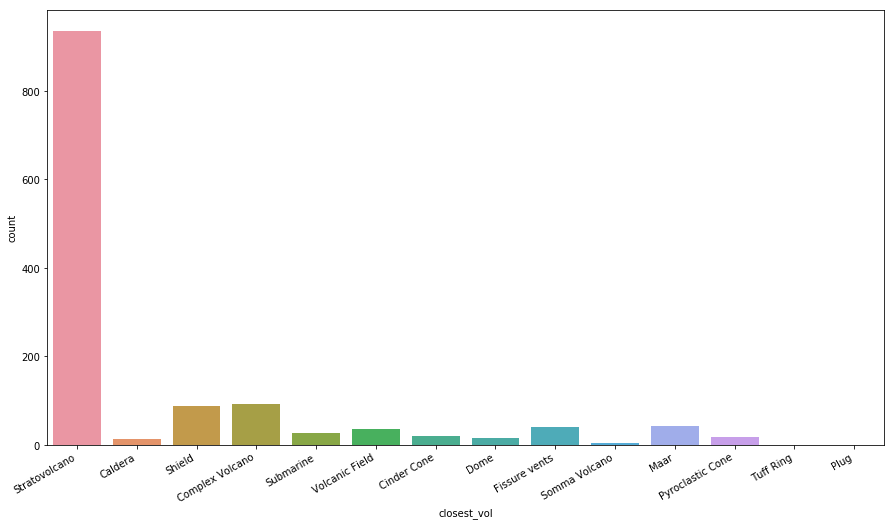

In [42]:
# At this point, we are wanting to visualize the distances between volcanoes and earthquakes. Notice here 
# how strato is way higher than the rest. This, we found, is a normalization issue. 
plt.subplots(figsize=(15, 8))
closest_vol_plot = sns.countplot(quake_vol_dist["closest_vol"])
closest_vol_plot.set_xticklabels(labels=vol_types, rotation=30, ha='right')

In [43]:
# The count between the volcano types and the dist df do not always match up. So, you need a way to make up for 
# the missing data.
quakes_closest = dict(quake_vol_dist["closest_vol"].value_counts())
volcanoe_types = dict(volcanoes_gdf['Type'].value_counts())

type_counts = list()
for key, value in volcanoe_types.items():
    key = key.strip()
    compare = {'type': key, 'volcanoes': value, 'earthquakes': quakes_closest.get(key, 0)}
    
    type_counts.append(compare)

type_counts

[{'earthquakes': 936, 'type': 'Stratovolcano', 'volcanoes': 275},
 {'earthquakes': 92, 'type': 'Caldera', 'volcanoes': 40},
 {'earthquakes': 36, 'type': 'Shield', 'volcanoes': 34},
 {'earthquakes': 41, 'type': 'Complex Volcano', 'volcanoes': 16},
 {'earthquakes': 27, 'type': 'Volcanic Field', 'volcanoes': 11},
 {'earthquakes': 13, 'type': 'Submarine', 'volcanoes': 11},
 {'earthquakes': 0, 'type': '', 'volcanoes': 10},
 {'earthquakes': 19, 'type': 'Cinder Cone', 'volcanoes': 9},
 {'earthquakes': 89, 'type': 'Dome', 'volcanoes': 8},
 {'earthquakes': 5, 'type': 'Fissure vents', 'volcanoes': 4},
 {'earthquakes': 21, 'type': 'Somma Volcano', 'volcanoes': 3},
 {'earthquakes': 44, 'type': 'Pyroclastic Cone', 'volcanoes': 3},
 {'earthquakes': 1, 'type': 'Maar', 'volcanoes': 3},
 {'earthquakes': 0, 'type': 'Flood Basalt', 'volcanoes': 2},
 {'earthquakes': 1, 'type': 'Plug', 'volcanoes': 1},
 {'earthquakes': 0, 'type': 'Tuff Ring', 'volcanoes': 1}]

In [44]:
"""CORRECTING FOR DIFFERENCES IN NUM OF VOLCANOES"""
# distance count as shown above
type_list = [vol_type['type'] for vol_type in type_counts]

dist_count = np.array([vol_type['earthquakes'] for vol_type in type_counts])
vol_count = np.array([vol_type['volcanoes'] for vol_type in type_counts])

normalized_dist = np.divide(dist_count, vol_count)

Text(0,0.5,'normalized distance')

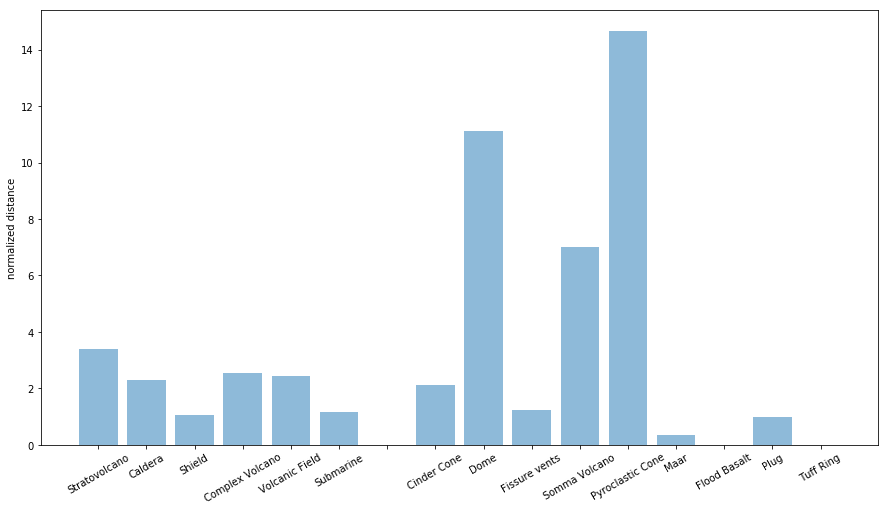

In [45]:
# Plotting out the normalized distances
# Notice the difference in the graph. Pyroclastic very obviously stands out
y_pos = np.arange(len(normalized_dist))
 
plt.figure(figsize=(15,8))
plt.bar(y_pos, normalized_dist, alpha=0.5)
plt.xticks(y_pos, type_list, rotation=30)
plt.ylabel('normalized distance')

[Text(0,0,'Stratovolcano'),
 Text(0,0,'Caldera'),
 Text(0,0,'Shield'),
 Text(0,0,'Complex Volcano'),
 Text(0,0,'Volcanic Field'),
 Text(0,0,'Submarine'),
 Text(0,0,''),
 Text(0,0,'Cinder Cone'),
 Text(0,0,'Dome'),
 Text(0,0,'Fissure vents'),
 Text(0,0,'Somma Volcano'),
 Text(0,0,'Pyroclastic Cone'),
 Text(0,0,'Maar'),
 Text(0,0,'Flood Basalt')]

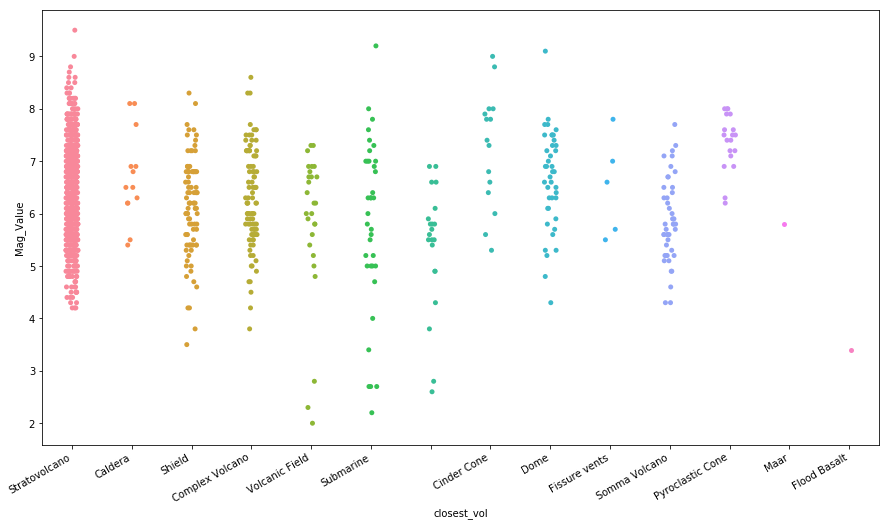

In [46]:
# Strip plot showing correlations between Magnitude and the Closest Volcano
plt.figure(figsize=(15,8))

sp = sns.stripplot(x="closest_vol", y="Mag_Value", data=quake_vol_dist, jitter=True)
sp.set_xticklabels(labels=type_list, rotation=30, ha="right")

In [47]:
# Get geometry column as series per type of plate
plate_types = ["SUB", "CCB", "CRB", "CTF", "OCB", "OSR", "OTF"]

plates_to_earthquake_logic = ClosestPointLogic(
    from_df=earthquakes_gdf,
    to_df=boundaries_gdf,
    categories=plate_types,
    extra_column_name='plates'
)

In [48]:
plates_series_geometry_list = plates_to_earthquake_logic.get_geometries_from_gdf(column='STEPCLASS')

quake_plate_dist = plates_to_earthquake_logic.create_total_dist_df(
    series_geometry_list=plates_series_geometry_list
)

quake_plate_dist = plates_to_earthquake_logic.calculate_nearest(
    to_column='closest_plate',
    dist_df=quake_plate_dist
)

boundary_distances_gdf = create_gdf(df=quake_plate_dist)

POINT (141.1000061035156 38.70000076293945)
2.87796912655
POINT (43.09999847412109 40.29999923706055)
10.2164176862
POINT (-66 11)
5.51961484164
POINT (100.0999984741211 26)
14.6776777621
POINT (28.70000076293945 43.40000152587891)
8.00104201674
POINT (142.5 40.5)
1.83482369725
POINT (173 -43)
2.67404001466
POINT (141.3000030517578 40.5)
3.00886722376
POINT (48.59999847412109 40.70000076293945)
15.2904280841
POINT (33.59999847412109 40.70000076293945)
5.9830792049
POINT (-91 14)
1.15906900969
POINT (129.6000061035156 43.20000076293945)
12.1209832785
POINT (77 40)
30.2976211772
POINT (138 -35)
29.0769332117
POINT (72.30000305175781 40.79999923706055)
33.5316400884
POINT (35.29999923706055 32.20000076293945)
2.61377725821
POINT (42.65000152587891 39.13999938964844)
9.24059221888
POINT (42.70000076293945 40.90000152587891)
10.2290398461
POINT (22.96999931335449 36.36000061035156)
0.83852832951
POINT (58.20000076293945 35.20000076293945)
23.7036339365
POINT (120.5 23.5)
1.86861660059
POINT

1.21408943611
POINT (161.0160064697266 -10.93200016021729)
0.0831590896778
POINT (131.9450073242188 32.00299835205078)
1.45071626282
POINT (-75.84999847412109 19.77000045776367)
6.96258624074
POINT (-71.9739990234375 8.14900016784668)
4.61003162537
POINT (115 31.39999961853027)
11.1865151208
POINT (126.1689987182617 0.257999986410141)
0.181158072069
POINT (-87.89399719238281 12.36400032043457)
0.790896209336
POINT (-104.1460037231445 19.45700073242188)
1.21211298048
POINT (-103.6320037841797 19.45199966430664)
1.42796074424
POINT (-104.3789978027344 19.02799987792969)
0.731513734834
POINT (23.73200035095215 40.33300018310547)
4.26315239407
POINT (96.69000244140625 39.77099990844727)
26.4627670095
POINT (144.6219940185547 39.2239990234375)
0.426709470848
POINT (-118 33.63000106811523)
9.49299945874
POINT (27.14999961853027 36.51599884033203)
1.86993003712
POINT (104.4339981079102 -5.521999835968018)
2.41898346906
POINT (103.5410003662109 31.80999946594238)
19.7376184415
POINT (56 32.099

8.58374499336
POINT (30.5 40)
4.63720713361
POINT (35.5 35.5)
1.22931891712
POINT (67.47899627685547 35.04199981689453)
32.5493475401
POINT (26.02599906921387 36.61700057983398)
2.38910971727
POINT (95.802001953125 21.9689998626709)
9.05932030115
POINT (70 23)
23.9417595218
POINT (140.3099975585938 35.64199829101562)
1.74532230078
POINT (54.40499877929688 27.28300094604492)
21.2717880351
POINT (8.899999618530273 36.20000076293945)
2.88876294147
POINT (121.5169982910156 23.91699981689453)
2.52100089708
POINT (22.60700035095215 39.26699829101562)
2.7313855569
POINT (28.60899925231934 36.38700103759766)
1.08590423118
POINT (31.04199981689453 40.67200088500977)
5.40636243732
POINT (52.70100021362305 36.09000015258789)
18.247724082
POINT (-99.2969970703125 16.88100051879883)
0.738915890617
POINT (99.20600128173828 45.15299987792969)
31.6958971603
POINT (47.71200180053711 34.27799987792969)
13.2217260863
POINT (-72.50299835205078 -16.77899932861328)
1.31442503732
POINT (-79.48000335693359 1.

22.0923330127
POINT (100.9929962158203 22.95299911499023)
12.8450840831
POINT (29.74600028991699 37.55500030517578)
2.1280531731
POINT (40.54199981689453 38.86800003051758)
7.29223223962
POINT (-69.052001953125 -25.42300033569336)
2.4939275381
POINT (-71.08499908447266 -32.55799865722656)
1.69394581638
POINT (153.906005859375 -5.519000053405762)
0.574628585021
POINT (77.24600219726562 39.84799957275391)
30.0437228974
POINT (-77.36199951171875 -2.825000047683716)
4.18801242945
POINT (103.6719970703125 28.87899971008301)
18.2780607045
POINT (-91.13700103759766 15.79699993133545)
2.690380964
POINT (-73.39900207519531 -14.18299961090088)
2.84921320371
POINT (167.3200073242188 -15.57800006866455)
1.05466566616
POINT (122.3249969482422 22.54899978637695)
2.08542709687
POINT (-76.77999877929688 -6.809999942779541)
4.64721891921
POINT (52.78900146484375 28.40800094604492)
19.3688846224
POINT (121.5339965820312 23.60400009155273)
2.24933344896
POINT (69.68399810791016 36.25500106811523)
31.7662

19.3208626327
POINT (-88.48999786376953 15.91199970245361)
3.78417060267
POINT (-80.00199890136719 -1.986999988555908)
1.56935326363
POINT (75.69300079345703 32.92200088500977)
25.2398391835
POINT (75.7760009765625 32.89300155639648)
25.1639618478
POINT (139.7400054931641 35.99700164794922)
1.43657226947
POINT (140.0619964599609 35.52500152587891)
1.47228280954
POINT (1.404000043869019 36.14300155639648)
9.32226991137
POINT (1.577000021934509 36.2130012512207)
9.13676055438
POINT (-98.23500061035156 18.17499923706055)
2.36508022351
POINT (-74.54499816894531 -13.34700012207031)
2.6369133324
POINT (88.79499816894531 27.39200019836426)
14.0631744429
POINT (15.3100004196167 40.78799819946289)
2.17396834914
POINT (15.29500007629395 40.76599884033203)
2.14801244833
POINT (50.64300155639648 34.47200012207031)
16.1460356798
POINT (50.63399887084961 34.42699813842773)
16.1379702843
POINT (139.2830047607422 -4.513000011444092)
2.90340422334
POINT (101.1679992675781 30.95599937438965)
19.49518007

1.79348934956
POINT (125.4789962768555 8.02299976348877)
1.70925616693
POINT (48.28499984741211 34.05899810791016)
13.8041044454
POINT (121.3529968261719 17.32399940490723)
2.14528252592
POINT (115.5660018920898 25.00200080871582)
5.93547664145
POINT (-70.00499725341797 -19.09199905395508)
1.64720809289
POINT (-70.90899658203125 -17.89999961853027)
1.5585180406
POINT (-78.03099822998047 -1.008999943733215)
3.19819125633
POINT (-118.1350021362305 34.06100082397461)
9.09614833151
POINT (-77.96099853515625 -8.166000366210938)
2.97757320082
POINT (-118.1370010375977 34.02000045776367)
9.12293015056
POINT (-115.7559967041016 33.25699996948242)
11.4252086049
POINT (124.1490020751953 -8.258999824523926)
4.59412012008
POINT (140.3220062255859 35.42100143432617)
1.69283626785
POINT (26.69400024414062 -26.90500068664551)
59.2433259811
POINT (91.57900238037109 24.71299934387207)
11.0088649842
POINT (-118.0500030517578 34.08000183105469)
9.14511286586
POINT (121.0849990844727 12.35499954223633)
4.

5.59418709922
POINT (-71.20600128173828 6.380000114440918)
5.96118028742
POINT (31.70100021362305 15.40100002288818)
18.9408109525
POINT (-92.64600372314453 14.75800037384033)
1.08312068653
POINT (-122.0039978027344 42.30500030517578)
3.19947166295
POINT (76.47799682617188 18.05999946594238)
16.1730593707
POINT (137.9259948730469 32.02999877929688)
1.35041363169
POINT (146.1309967041016 -5.843999862670898)
2.90474673861
POINT (146.2799987792969 -5.876999855041504)
2.76162616449
POINT (-86.08399963378906 11.7180004119873)
1.44340411059
POINT (75.50499725341797 39.32600021362305)
30.5001047855
POINT (-118.5630035400391 34.16400146484375)
8.71723466689
POINT (127.7730026245117 1.042999982833862)
1.42408726065
POINT (30.08099937438965 0.5580000281333923)
33.833785623
POINT (104.254997253418 -4.999000072479248)
2.80616129413
POINT (60.53200149536133 30.78800010681152)
26.3370672247
POINT (52.63800048828125 29.14299964904785)
18.9952422905
POINT (-72.81400299072266 19.94099998474121)
6.53840

2.61114988839
POINT (102.0309982299805 -4.760000228881836)
1.304895
POINT (101.9530029296875 -4.151000022888184)
1.60684903975
POINT (33.00500106811523 40.73699951171875)
6.13688194394
POINT (101.8479995727539 -4.651000022888184)
1.23227149564
POINT (121.1809997558594 23.86800003051758)
2.35183689496
POINT (139.1710052490234 34.22200012207031)
0.72870789931
POINT (-86.06600189208984 11.92800045013428)
1.59621842132
POINT (29.3439998626709 40.85699844360352)
5.43188540312
POINT (70.94300079345703 36.24499893188477)
30.8847283191
POINT (102.2399978637695 25.72599983215332)
15.7395570938
POINT (-80.52200317382812 -1.945999979972839)
1.0567137696
POINT (30.80599975585938 -7.965000152587891)
42.3172785516
POINT (-77.81099700927734 7.091000080108643)
0.71483133241
POINT (4.837999820709229 36.4370002746582)
5.97408819402
POINT (152.2680053710938 -3.996000051498413)
1.68847762643
POINT (49.92900085449219 40.19800186157227)
16.3509833503
POINT (49.9119987487793 40.1609992980957)
16.3227164983
P

60.1035820855
POINT (125.0299987792969 46.88399887084961)
17.5007467304
POINT (-76.41400146484375 -5.721000194549561)
5.37405194796
POINT (73.58399963378906 34.46500015258789)
27.7888606436
POINT (73.92900085449219 33.97700119018555)
27.1950727565
POINT (26.75300025939941 38.15800094604492)
3.48535997973
POINT (107.7979965209961 23.60400009155273)
12.6888080951
POINT (108.2259979248047 9.972999572753906)
12.8442509085
POINT (115.6630020141602 29.7140007019043)
9.39431940345
POINT (55.83300018310547 26.7859992980957)
22.783347187
POINT (29.78899955749512 -6.245999813079834)
40.5803658675
POINT (71.12000274658203 36.28499984741211)
30.7932376025
POINT (79.20099639892578 30.45999908447266)
21.1176413458
POINT (88.38800048828125 27.38199996948242)
14.1537728035
POINT (33.58300018310547 -21.32399940490723)
55.616088086
POINT (73.88700103759766 33.12900161743164)
26.59797327
POINT (127.213996887207 -3.595000028610229)
1.75500693806
POINT (5.328000068664551 36.62300109863281)
5.45012511567
PO

POINT (125 6)
4.41957882609
POINT (104 29)
6.65677436902
POINT (-74 4)
0.219404869467
POINT (117.2429962158203 23.54000091552734)
1.89567455441
POINT (-117.4400024414062 33.8120002746582)
0.454818732271
POINT (123.5630035400391 5.652999877929688)
5.1179308997
POINT (150.2530059814453 46.8120002746582)
7.61382795886
POINT (-67.63099670410156 18.47299957275391)
2.69715898801
POINT (152.6289978027344 -5.47700023651123)
2.63589960653
POINT (122.0800018310547 23.8129997253418)
1.35650380385
POINT (-97.08000183105469 19.27000045776367)
13.8006483715
POINT (44.09999847412109 42)
4.19499629371
POINT (10.30000019073486 44.29999923706055)
5.6154737471
POINT (105.3170013427734 36.60100173950195)
8.05821340079
POINT (-68.40000152587891 -32.70000076293945)
12.3282310616
POINT (39.44499969482422 15.60999965667725)
16.3062574893
POINT (127.2570037841797 7.896999835968018)
5.58120074354
POINT (139.8000030517578 35.20000076293945)
0.431389898085
POINT (122.0400009155273 24.50600051879883)
0.84016356545

5.54592330343
POINT (-74.91999816894531 -14.97500038146973)
3.90109938898
POINT (20.39999961853027 41.70000076293945)
3.58694220475
POINT (36.45000076293945 40.67100143432617)
3.09279073073
POINT (30.5 40.79999923706055)
7.15106277479
POINT (-101.5 17.75)
16.6450331631
POINT (-72 -30.75)
12.6296852296
POINT (30.5 40.59999847412109)
7.05810840298
POINT (110 -9.5)
11.0505375887
POINT (134 35.25)
4.03595800275
POINT (34 41)
4.55615012922
POINT (121.5 22.89999961853027)
1.12183852018
POINT (-68.75 -31.25)
11.1689726027
POINT (32.5 41.5)
5.93552895705
POINT (84 44)
14.2491432023
POINT (54.5 36.79999923706055)
7.52371620291
POINT (26.70000076293945 39.40000152587891)
6.54537720186
POINT (136 33.75)
2.90746298343
POINT (136.75 34.75)
1.77593149225
POINT (142.5 41.25)
4.96608034571
POINT (35.79999923706055 37.40000152587891)
0.990002786222
POINT (-70.5 -33.25)
13.7678592744
POINT (119 39.5)
0.767259161163
POINT (63 24.5)
2.03143003818
POINT (5 36)
1.05465793234
POINT (31.79999923706055 38.2000

6.86012088611
POINT (40.40800094604492 39.50199890136719)
0.674093567335
POINT (-73.072998046875 6.788000106811523)
1.05123211148
POINT (-67.30999755859375 10.55500030517578)
2.0338473313
POINT (100.2320022583008 31.63100051879883)
4.57228353312
POINT (122.2210006713867 24.4640007019043)
1.01685667092
POINT (20.45599937438965 41.37900161743164)
3.26863615915
POINT (73.77400207519531 17.39399909973145)
10.4966645786
POINT (-69.947998046875 -21.86400032043457)
6.42218033896
POINT (13 38)
1.6962962595
POINT (24.94599914550781 39.37200164794922)
4.8304183227
POINT (132.1920013427734 32.48199844360352)
3.6709040354
POINT (143.3459930419922 40.90299987792969)
5.85226105558
POINT (172.1230010986328 -41.74300003051758)
1.30985411319
POINT (-77.1510009765625 -5.558000087738037)
3.87437496755
POINT (-100.2590026855469 17.51499938964844)
15.4356012264
POINT (122.0780029296875 16.38400077819824)
5.4941224376
POINT (-97.77100372314453 16.49399948120117)
12.7630829477
POINT (119.6900024414062 0.0579

POINT (-68.89600372314453 -20.47200012207031)
4.83626766021
POINT (26.67700004577637 -27.97900009155273)
1.21370598959
POINT (101.0240020751953 27.33600044250488)
3.57180338519
POINT (91.01399993896484 38.18500137329102)
10.9443060692
POINT (26.70199966430664 45.7760009765625)
9.9953655087
POINT (122.2850036621094 16.7549991607666)
5.21009017304
POINT (56.36299896240234 27.58300018310547)
0.223215598129
POINT (40.05699920654297 38.64699935913086)
0.160864300901
POINT (50.64300155639648 31.95400047302246)
1.56492672768
POINT (160.8159942626953 -10.00899982452393)
6.53507510091
POINT (44.32400131225586 38.89599990844727)
1.62604661803
POINT (118.370002746582 -11.18000030517578)
3.42087329643
POINT (118.379997253418 -11.12600040435791)
3.41499977481
POINT (125.3259963989258 -8.13599967956543)
1.14637555665
POINT (-76.15899658203125 7.35099983215332)
1.2952196461
POINT (-67.77999877929688 -31.08200073242188)
10.5970290596
POINT (56.57799911499023 27.6870002746582)
0.338143452507
POINT (56.

15.0602418869
POINT (102.8850021362305 25.89100074768066)
5.70886481036
POINT (120.8119964599609 16.54100036621094)
5.00000615478
POINT (151.0559997558594 -5.60099983215332)
2.18325427548
POINT (70.85700225830078 36.16500091552734)
2.18304568891
POINT (75.26399993896484 39.44699859619141)
5.52930703428
POINT (75.41500091552734 39.35599899291992)
5.53029908761
POINT (136.0930023193359 -4.064000129699707)
2.8382002676
POINT (-102.379997253418 18.42000007629395)
17.733864887
POINT (-101.6230010986328 17.83099937438965)
16.7913627916
POINT (69.80999755859375 40.33700180053711)
6.24469849542
POINT (6.846000194549561 36.38600158691406)
1.78384921363
POINT (15.06799983978271 37.6879997253418)
0.61340473268
POINT (-77.43699645996094 -9.51200008392334)
6.10029985202
POINT (-115.8000030517578 47.47000122070312)
11.2020847118
POINT (-71.75700378417969 -13.40200042724609)
0.898678407072
POINT (76.39700317382812 32.11800003051758)
0.725485753605
POINT (37.78099822998047 37.99900054931641)
0.1103752

13.2825227564
POINT (98.84799957275391 22.4069995880127)
3.01860446202
POINT (72.44899749755859 41.00099945068359)
6.31900736728
POINT (71.27200317382812 33.31800079345703)
0.0119697106971
POINT (-116.5199966430664 34.18999862670898)
0.203726614512
POINT (73.58799743652344 42.11100006103516)
7.51429817871
POINT (66.81999969482422 29.21100044250488)
0.75658230004
POINT (-87.37999725341797 11.72700023651123)
1.66189189924
POINT (52.14699935913086 29.13199996948242)
1.04931762558
POINT (26.65999984741211 -6.151000022888184)
16.4191637627
POINT (31.14399909973145 29.7140007019043)
4.48695789553
POINT (-76.76399993896484 7.092999935150146)
1.16259803427
POINT (31.53499984741211 29.7549991607666)
4.11016591931
POINT (-4.290999889373779 31.27499961853027)
2.82366361713
POINT (45.09600067138672 42.56100082397461)
5.11569268215
POINT (121.8320007324219 -8.498000144958496)
1.70745276217
POINT (100.7519989013672 26.32799911499023)
3.55708198145
POINT (26.79999923706055 -28.02799987792969)
1.27640

3.3106724785
POINT (30.0890007019043 40.73600006103516)
7.48636333613
POINT (120.8769989013672 23.81900024414062)
0.359160233185
POINT (121.0869979858398 23.8129997253418)
0.545021937362
POINT (29.35000038146973 40.73600006103516)
8.1544980674
POINT (-96.90499877929688 16.05500030517578)
11.7931517208
POINT (120.443000793457 23.5310001373291)
0.00386414501951
POINT (30.72400093078613 40.69499969482422)
6.90409673276
POINT (30.24699974060059 40.7400016784668)
7.34709654308
POINT (31.2189998626709 40.80300140380859)
6.52917124068
POINT (102.8450012207031 24.58600044250488)
6.21203206386
POINT (168.2389984130859 -16.31599998474121)
2.78646175309
POINT (42.35400009155273 40.48199844360352)
2.10482022035
POINT (119.7760009765625 15.7790002822876)
4.92301582259
POINT (124.515998840332 11.29599952697754)
9.44306239008
POINT (105.4980010986328 -6.822999954223633)
14.3541947468
POINT (-1.315999984741211 35.20999908447266)
0.56275687406
POINT (101.1179962158203 25.54899978637695)
4.23509047342
P

0.18328240051
POINT (130.2089996337891 33.80199813842773)
3.10634393444
POINT (97.09700012207031 2.069000005722046)
12.3416103441
POINT (48.66899871826172 33.65499877929688)
1.42312754801
POINT (146.8459930419922 -6.355000019073486)
0.286652009387
POINT (-69.197998046875 -20.00699996948242)
4.72458297007
POINT (27.43499946594238 -26.4680004119873)
0.069618668704
POINT (125.0299987792969 46.88399887084961)
5.22811665752
POINT (-76.41400146484375 -5.721000194549561)
4.44399348604
POINT (73.58399963378906 34.46500015258789)
0.585250341629
POINT (73.92900085449219 33.97700119018555)
0.446536900882
POINT (26.75300025939941 38.15800094604492)
6.46270291887
POINT (107.7979965209961 23.60400009155273)
5.82576601499
POINT (108.2259979248047 9.972999572753906)
7.80830498234
POINT (115.6630020141602 29.7140007019043)
3.49542400875
POINT (55.83300018310547 26.7859992980957)
0.223897245548
POINT (29.78899955749512 -6.245999813079834)
15.7459790143
POINT (71.12000274658203 36.28499984741211)
2.08866

3.88980532669
POINT (130.6000061035156 31.60000038146973)
0.395105807693
POINT (140.3999938964844 39.5)
11.5784330004
POINT (15.19999980926514 37.70000076293945)
0.161713457278
POINT (137 -2)
0.497805182777
POINT (102.5 -4.5)
8.50695115773
POINT (91.5 43.5)
15.0530656229
POINT (32.5 37.5)
3.54898253025
POINT (13.5 42)
4.27466045435
POINT (143.6000061035156 42.09999847412109)
11.9942801769
POINT (-115.5 32.79999923706055)
0.111072570725
POINT (-89 14)
1.06413202197
POINT (91.5 29.5)
13.5395069334
POINT (120.5 23.89999961853027)
1.33465598694
POINT (121 24)
0.898947161962
POINT (120.9000015258789 21.89999961853027)
2.87146409858
POINT (116 -7)
7.06647472224
POINT (114 31)
2.47463633692
POINT (125 6)
4.82251604456
POINT (104 29)
1.34433269731
POINT (-74 4)
7.50854140296
POINT (117.2429962158203 23.54000091552734)
2.19384999689
POINT (-117.4400024414062 33.8120002746582)
1.85306820914
POINT (123.5630035400391 5.652999877929688)
5.632234032
POINT (150.2530059814453 46.8120002746582)
10.6630

3.49756379575
POINT (139.8289947509766 44.50799942016602)
9.60020288559
POINT (26.65500068664551 45.77299880981445)
5.02010401395
POINT (43.5 16.39999961853027)
3.26818388574
POINT (58.59999847412109 33.5)
9.94610252145
POINT (-102.9570007324219 18.67700004577637)
13.2461208011
POINT (127.1999969482422 47)
6.55788158277
POINT (99.40799713134766 23.51399993896484)
6.64856652473
POINT (92.47799682617188 12.14900016784668)
3.12315688947
POINT (43.29999923706055 39.5)
7.3740386202
POINT (102.3000030517578 31.70000076293945)
4.25110415369
POINT (39.40000152587891 39.70000076293945)
4.1748376598
POINT (132 32)
0.366427727438
POINT (120.390998840332 23.25099945068359)
1.86425865376
POINT (99.14499664306641 21.07600021362305)
4.62577055153
POINT (100.3000030517578 23.10000038146973)
6.05095279338
POINT (-79.90200042724609 0.01200000010430813)
7.39875930442
POINT (-90.91300201416016 13.77999973297119)
0.311268535712
POINT (-74.91999816894531 -14.97500038146973)
0.299808093417
POINT (20.39999961

11.0519940334
POINT (22.29899978637695 38.3390007019043)
0.00383686515198
POINT (138.2779998779297 34.84199905395508)
6.99716355031
POINT (-122.3349990844727 47.31700134277344)
15.6096299275
POINT (22.42600059509277 38.39099884033203)
0.0739138616759
POINT (-95.84600067138672 16.17799949645996)
5.75429891112
POINT (87.75499725341797 43.84000015258789)
18.3107859806
POINT (21.75699996948242 39.04399871826172)
0.638531403904
POINT (103.1709976196289 26.15999984741211)
2.20486474039
POINT (114.9629974365234 37.38800048828125)
2.5592996499
POINT (122.6949996948242 24.30699920654297)
0.677216038952
POINT (29.87299919128418 0.8420000076293945)
0.371638227738
POINT (114.9909973144531 37.55099868774414)
2.722934024
POINT (69.12999725341797 41.15999984741211)
9.28258340326
POINT (80.85399627685547 29.55400085449219)
10.6950193369
POINT (68.62899780273438 30.05100059509277)
1.88829871103
POINT (78.89199829101562 28.61599922180176)
8.95868462494
POINT (41.58000183105469 39.1609992980957)
5.662399

8.79256830887
POINT (98.66699981689453 24.76799964904785)
6.91905103943
POINT (117.8880004882812 39.60499954223633)
1.64822695058
POINT (118.359001159668 39.72299957275391)
2.05363824906
POINT (104.0879974365234 32.75299835205078)
4.11046187059
POINT (124.088996887207 6.291999816894531)
5.65261810022
POINT (122.9599990844727 7.258999824523926)
7.13551747478
POINT (29.01499938964844 37.74300003051758)
0.737132348692
POINT (104.181999206543 32.48099899291992)
3.82629716635
POINT (13.18099975585938 46.3390007019043)
8.40734063107
POINT (13.20600032806396 46.31399917602539)
8.37613868052
POINT (13.08699989318848 46.35400009155273)
8.44959945915
POINT (-78.73200225830078 -0.7260000109672546)
8.3403687514
POINT (139.9909973144531 -4.474999904632568)
3.64580679499
POINT (101.0210037231445 27.55400085449219)
3.93435982714
POINT (59.18000030517578 33.81999969482422)
9.61741133976
POINT (44.03099822998047 39.08200073242188)
7.92219071122
POINT (-68.89600372314453 -20.47200012207031)
1.0284750984

6.86583272376
POINT (10.19400024414062 43.61600112915039)
7.61042202172
POINT (13.88899993896484 41.73799896240234)
3.85865443866
POINT (13.90100002288818 41.75500106811523)
3.86840888522
POINT (17.82900047302246 42.9739990234375)
5.1625301879
POINT (121.6019973754883 32.60400009155273)
1.17352084308
POINT (-80.80000305175781 46.58000183105469)
31.1091021859
POINT (-69.37100219726562 17.98100090026855)
4.84532638221
POINT (-69.23300170898438 18.03899955749512)
4.93932261963
POINT (137.4660034179688 35.80099868774414)
6.90338819715
POINT (-115.9869995117188 47.45999908447266)
14.2283724851
POINT (42.24100112915039 40.89199829101562)
7.11848774784
POINT (42.44699859619141 40.71099853515625)
7.18475424385
POINT (92.86399841308594 24.68400001525879)
11.1646924665
POINT (-68.59300231933594 -33.10900115966797)
11.6083348139
POINT (52.97200012207031 28.35199928283691)
14.2697113437
POINT (-71.76200103759766 -33.13199996948242)
11.7555700337
POINT (14.26299953460693 41.63100051879883)
3.604941

0.223660568105
POINT (27.34900093078613 -26.38999938964844)
0.595402137179
POINT (103.7180023193359 37.09600067138672)
7.42820313796
POINT (70.42900085449219 35.09000015258789)
3.21410948815
POINT (55.45700073242188 28.24200057983398)
11.7876474479
POINT (97.40499877929688 3.938999891281128)
0.809890015543
POINT (15.40200042724609 37.2859992980957)
0.334074110661
POINT (121.6449966430664 23.88299942016602)
0.811026797987
POINT (22.34600067138672 40.97700119018555)
1.96565950693
POINT (-84.22899627685547 9.982000350952148)
4.3305169656
POINT (95.88999938964844 23.55900001525879)
8.54890501681
POINT (70.40299987792969 35.94400024414062)
4.05727542271
POINT (6.760000228881836 44.8849983215332)
11.0549541305
POINT (113.9889984130859 39.94699859619141)
1.58151784347
POINT (-77.08100128173828 -5.97700023651123)
7.5405793332
POINT (68.26899719238281 37.4640007019043)
5.79763289514
POINT (-83.07199859619141 9.673000335693359)
3.25486775929
POINT (41.16899871826172 39.61299896240234)
5.51632848

2.36274320101
POINT (-71.16699981689453 -30.87800025939941)
9.44287633407
POINT (-71.38700103759766 46.77099990844727)
33.4689184227
POINT (92.71499633789062 22.26000022888184)
8.97006892204
POINT (114.5230026245117 41.13700103759766)
0.744040799248
POINT (-70.14700317382812 -23.85000038146973)
2.35153722753
POINT (70.00399780273438 37.08000183105469)
5.16737376717
POINT (71.07399749755859 36.47900009155273)
4.70422949807
POINT (57.58499908447266 30.12599945068359)
9.77910271818
POINT (12.91899967193604 43.2239990234375)
5.62619028878
POINT (60.0629997253418 32.44699859619141)
8.15580762805
POINT (13.65299987792969 46.27099990844727)
8.21565450985
POINT (-65.4010009765625 -17.78300094604492)
3.67540596102
POINT (70.07499694824219 37.18500137329102)
5.27367866562
POINT (35.32500076293945 36.90299987792969)
1.15394439119
POINT (-28.56599998474121 38.62099838256836)
22.8267947794
POINT (48.52500152587891 38.72600173950195)
12.2230741119
POINT (120.7109985351562 23.50300025939941)
1.468959

3.40814625313
POINT (-70.69300079345703 19.76600074768066)
6.45609028035
POINT (143.8780059814453 41.86399841308594)
12.2593335138
POINT (87.81700134277344 50.03099822998047)
16.661584119
POINT (101.2559967041016 25.88199996948242)
4.1156652407
POINT (100.9779968261719 38.38600158691406)
8.15707746708
POINT (100.9940032958984 38.37099838256836)
8.15457866179
POINT (103.8649978637695 34.7130012512207)
5.94587278288
POINT (103.9739990234375 27.46199989318848)
1.04848924386
POINT (125.4160003662109 12.11299991607666)
10.1780916875
POINT (80.54599761962891 42.8849983215332)
15.2587520029
POINT (-121.0749969482422 35.62900161743164)
5.91211809602
POINT (-82.84200286865234 8.369000434875488)
2.29292339312
POINT (58.26800155639648 28.95000076293945)
8.97991568152
POINT (115.7580032348633 -8.348999977111816)
8.29948273869
POINT (135.5970001220703 -3.66100001335144)
0.079308562556
POINT (73.17800140380859 34.75099945068359)
4.30417773419
POINT (73.16899871826172 34.77199935913086)
4.31131048095

0.577793661624
POINT (141.3000030517578 40.5)
5.86212969917
POINT (48.59999847412109 40.70000076293945)
5.8267311178
POINT (33.59999847412109 40.70000076293945)
0.349453147881
POINT (-91 14)
3.97564208651
POINT (129.6000061035156 43.20000076293945)
11.4080950353
POINT (77 40)
7.92258455304
POINT (138 -35)
27.314772505
POINT (72.30000305175781 40.79999923706055)
9.24877896056
POINT (35.29999923706055 32.20000076293945)
0.194462257844
POINT (42.65000152587891 39.13999938964844)
1.64586399828
POINT (42.70000076293945 40.90000152587891)
2.48978094351
POINT (22.96999931335449 36.36000061035156)
1.92638711933
POINT (58.20000076293945 35.20000076293945)
8.73889604296
POINT (120.5 23.5)
1.48521580923
POINT (27 37.75)
1.27071533486
POINT (101 30)
4.21125218908
POINT (120.3000030517578 23.5)
1.40729853358
POINT (76 33)
0.873696743727
POINT (19.60000038146973 42.09999847412109)
3.72427151086
POINT (132.5 34.09999847412109)
3.83061430577
POINT (16 39)
1.53250154975
POINT (24 40)
0.0820243866176
PO

3.89075912243
POINT (-104.1460037231445 19.45700073242188)
11.914897206
POINT (-103.6320037841797 19.45199966430664)
12.2767907069
POINT (-104.3789978027344 19.02799987792969)
12.0760428172
POINT (23.73200035095215 40.33300018310547)
0.495100961889
POINT (96.69000244140625 39.77099990844727)
12.0942430923
POINT (144.6219940185547 39.2239990234375)
6.78319057327
POINT (-118 33.63000106811523)
1.40190695835
POINT (27.14999961853027 36.51599884033203)
1.336348603
POINT (104.4339981079102 -5.521999835968018)
12.8544627229
POINT (103.5410003662109 31.80999946594238)
7.3294313598
POINT (56 32.09999847412109)
5.54920943049
POINT (102.6999969482422 23.70000076293945)
4.98697581445
POINT (86.76200103759766 26.77300071716309)
9.63191870166
POINT (27.5 40.5)
0.378228766754
POINT (24.70299911499023 36.08399963378906)
2.94746384274
POINT (53.29999923706055 36.29999923706055)
7.08634738921
POINT (53.62099838256836 36.43199920654297)
7.31788171735
POINT (120.6129989624023 24.36400032043457)
0.9381290

POINT (52.70100021362305 36.09000015258789)
6.71631466577
POINT (-99.2969970703125 16.88100051879883)
11.5911306108
POINT (99.20600128173828 45.15299987792969)
14.8193580945
POINT (47.71200180053711 34.27799987792969)
2.73000418361
POINT (-72.50299835205078 -16.77899932861328)
4.35133871344
POINT (-79.48000335693359 1.054000020027161)
2.15358850006
POINT (103.9120025634766 31.57699966430664)
7.51679030046
POINT (124.3509979248047 24.4330005645752)
1.83976911076
POINT (-79.57499694824219 0.7059999704360962)
2.25128503776
POINT (-136.6649932861328 58.36999893188477)
0.341712092052
POINT (47.86899948120117 34.25899887084961)
2.88814521326
POINT (-70.11199951171875 -33.78499984741211)
12.0645198363
POINT (112.5 -9.5)
8.12497070764
POINT (122.7919998168945 24.6870002746582)
1.101268753
POINT (159.6450042724609 53.35100173950195)
7.96898798302
POINT (-97.14499664306641 17.45000076293945)
9.49797997321
POINT (-68.88099670410156 -20.36899948120117)
1.63521587518
POINT (120.9700012207031 21.951

1.70159724912
POINT (167.3200073242188 -15.57800006866455)
12.2943912781
POINT (122.3249969482422 22.54899978637695)
1.79124241698
POINT (-76.77999877929688 -6.809999942779541)
5.11862668465
POINT (52.78900146484375 28.40800094604492)
1.91012590965
POINT (121.5339965820312 23.60400009155273)
0.695577138508
POINT (69.68399810791016 36.25500106811523)
5.280292642
POINT (73.32099914550781 35.94900131225586)
4.43609399034
POINT (-86.12799835205078 12.34700012207031)
4.19701343775
POINT (-102.9599990844727 18.45499992370605)
13.4587235508
POINT (100.5449981689453 31.35300064086914)
4.77276339475
POINT (122.8040008544922 13.41499996185303)
2.34559467884
POINT (-84.86000061035156 10.67300033569336)
6.122203319
POINT (-78.11399841308594 4.907000064849854)
2.48755409455
POINT (101.0780029296875 23.00300025939941)
5.15336755153
POINT (-96.60800170898438 18.23299980163574)
9.10338280983
POINT (52.95100021362305 30.53499984741211)
2.1220474823
POINT (-28.32900047302246 38.48600006103516)
19.695105

10.6866238774
POINT (-74.54499816894531 -13.34700012207031)
1.5351734611
POINT (88.79499816894531 27.39200019836426)
7.84689858585
POINT (15.3100004196167 40.78799819946289)
3.17318035183
POINT (15.29500007629395 40.76599884033203)
3.15137980642
POINT (50.64300155639648 34.47200012207031)
4.91147960457
POINT (50.63399887084961 34.42699813842773)
4.86741336869
POINT (139.2830047607422 -4.513000011444092)
0.116355810897
POINT (101.1679992675781 30.95599937438965)
4.92507010234
POINT (14.61400032043457 40.99499893188477)
3.45793179686
POINT (26.60700035095215 -26.625)
0.143422479832
POINT (22.97599983215332 38.15900039672852)
0.268489030222
POINT (23.17000007629395 38.09700012207031)
0.463259949293
POINT (23.29999923706055 38.19699859619141)
0.512949935845
POINT (23.33499908447266 38.18099975585938)
0.550814695867
POINT (20.8129997253418 39.38199996948242)
0.985543879213
POINT (-74.37300109863281 -13.11600017547607)
1.26676897495
POINT (57.68600082397461 29.85799980163574)
3.38490839305
P

0.101531144851
POINT (124.1490020751953 -8.258999824523926)
2.18002501658
POINT (140.3220062255859 35.42100143432617)
1.05460074353
POINT (26.69400024414062 -26.90500068664551)
0.0981925807913
POINT (91.57900238037109 24.71299934387207)
4.49191929594
POINT (-118.0500030517578 34.08000183105469)
1.3905224281
POINT (121.0849990844727 12.35499954223633)
3.44178076695
POINT (121.6790008544922 23.98600006103516)
0.286985707424
POINT (95.12599945068359 25.10499954223633)
1.12712403494
POINT (160.9329986572266 -10.31999969482422)
7.050791841
POINT (51.58499908447266 29.94400024414062)
0.642447828166
POINT (51.65499877929688 29.88599967956543)
0.672656184579
POINT (86.61799621582031 26.76300048828125)
9.76950173353
POINT (18.48900032043457 49.88600158691406)
11.3909710343
POINT (146.2259979248047 -6.061999797821045)
0.780921178011
POINT (-90.50099945068359 13.90799999237061)
3.6341340074
POINT (99.68099975585938 22.90900039672852)
3.76840094301
POINT (99.41100311279297 23.18600082397461)
3.477

1.29012555829
POINT (-67.51200103759766 -13.85999965667725)
4.76998003912
POINT (52.67100143432617 29.05299949645996)
1.66400948827
POINT (-97.31199645996094 14.88700008392334)
9.68552264363
POINT (-0.08399999886751175 35.4640007019043)
5.90357544556
POINT (27.40500068664551 -26.44700050354004)
0.870357850381
POINT (118.7190017700195 22.55500030517578)
0.505895350196
POINT (147.3529968261719 43.86299896240234)
11.3098501195
POINT (127.9800033569336 -1.205999970436096)
0.622526653325
POINT (121.0589981079102 13.54300022125244)
2.32027082921
POINT (143.4299926757812 40.52299880981445)
6.9249853734
POINT (135.0249938964844 34.58000183105469)
4.231322109
POINT (-72.93599700927734 5.044000148773193)
0.311902493758
POINT (-109.7850036621094 41.48799896240234)
10.0389391496
POINT (-76.58899688720703 4.052000045776367)
2.36856203195
POINT (121.7060012817383 24.23299980163574)
0.0754581663224
POINT (32.26900100708008 35.06000137329102)
2.24788395201
POINT (-77.30699920654297 1.281999945640564)


POINT (49.92900085449219 40.19800186157227)
6.64758883744
POINT (49.9119987487793 40.1609992980957)
6.61337485745
POINT (54.80099868774414 39.53200149536133)
10.6348329532
POINT (31.26499938964844 38.45100021362305)
2.16912330068
POINT (-88.70200347900391 13.07600021362305)
3.32250981269
POINT (70.28700256347656 23.40200042724609)
3.81168106316
POINT (-89.00099945068359 13.60000038146973)
2.94297155498
POINT (-89.10600280761719 13.78699970245361)
2.82559626136
POINT (101.0790023803711 29.45899963378906)
4.01306975891
POINT (-122.5810012817383 47.09000015258789)
7.02296684919
POINT (132.5399932861328 34.10800170898438)
3.86740162299
POINT (99.05100250244141 24.80599975585938)
2.58353452037
POINT (100.9010009765625 27.61899948120117)
3.43100506927
POINT (69.32399749755859 35.10499954223633)
4.20406445262
POINT (6.869999885559082 49.14699935913086)
14.3106843707
POINT (-73.50499725341797 -16.38500022888184)
3.9058369802
POINT (-71.93099975585938 -17.5319995880127)
4.37252345556
POINT (11.

22.0925055351
POINT (110.4459991455078 -7.960999965667725)
9.43956270266
POINT (55.84299850463867 26.75900077819824)
1.16876035585
POINT (107.411003112793 -9.253999710083008)
12.7313944908
POINT (104.1380004882812 27.9950008392334)
5.75807035026
POINT (68.8280029296875 37.25500106811523)
6.41053086494
POINT (104.1510009765625 28.01199913024902)
5.76350771495
POINT (-61.75799942016602 10.81400012969971)
0.375514176353
POINT (118.7770004272461 -8.25100040435791)
1.7874932151
POINT (99.85900115966797 0.6259999871253967)
5.19438116995
POINT (120.5469970703125 21.79899978637695)
1.0411223547
POINT (126.2819976806641 1.065000057220459)
1.37899118989
POINT (100.4700012207031 -0.4799999892711639)
6.44117958288
POINT (136.5399932861328 37.34000015258789)
3.55920621546
POINT (157.0599975585938 -8.430000305175781)
2.97992002569
POINT (-72.66999816894531 -45.2400016784668)
7.67685586414
POINT (101.0100021362305 23.02000045776367)
5.0842213715
POINT (138.4600067138672 37.52000045776367)
2.622804586

8.88750777506
POINT (125.9540023803711 7.02299976348877)
4.76624028111
POINT (83.90299987792969 36.63199996948242)
22.5017359251
POINT (73.39700317382812 40.56499862670898)
18.2189368152
POINT (41.87599945068359 39.86399841308594)
21.9632711989
POINT (100.4940032958984 25.6879997253418)
13.8352083965
POINT (134.8000030517578 35.59999847412109)
4.50361989617
POINT (-119.5999984741211 34.5)
16.7341063513
POINT (58.09999847412109 34.59999847412109)
10.1605335089
POINT (51.20000076293945 28.5)
7.77448794972
POINT (29.24600028991699 35.7869987487793)
9.48615663316
POINT (26.88800048828125 36.60499954223633)
7.01016126202
POINT (101.5220031738281 -0.05099999904632568)
6.88875282824
POINT (43.70000076293945 40.70000076293945)
21.5407399186
POINT (-86.73600006103516 12.67000007629395)
6.0194518947
POINT (134.9239959716797 35.80199813842773)
4.27023826045
POINT (102 24.10000038146973)
13.5767430709
POINT (-69.67500305175781 -32.47700119018555)
25.9791389044
POINT (102.3109970092773 37.386001586

18.3979669801
POINT (122 10.5)
9.49863674429
POINT (-70.25 -17.5)
26.5854224905
POINT (100.5 29.5)
17.0944945816
POINT (-76.5 -13)
20.4792624135
POINT (135.25 33.75)
4.77119460932
POINT (99.69999694824219 26.39999961853027)
13.9992746952
POINT (136 36.5)
3.05080317294
POINT (20.5 38.5)
0.774728111983
POINT (-65 -24.5)
32.3113210036
POINT (58 37.5)
13.0580807548
POINT (104 27.39999961853027)
17.3572905452
POINT (-106.5 22)
0.438749358974
POINT (83.5 41)
24.8469858937
POINT (-122.5 47.25)
28.9150436451
POINT (-73.5 -38)
21.8464956
POINT (70.5 39)
15.6086100598
POINT (26.29999923706055 38.59999847412109)
6.33789020693
POINT (-78.25 -1.5)
8.86164143937
POINT (40.59999847412109 39.5)
20.6614230181
POINT (-71 -54)
7.51108314426
POINT (-71 -54)
7.51108314426
POINT (121 18)
5.82533719491
POINT (-72 -13.5)
22.2212328416
POINT (112 -6.25)
8.6846239412
POINT (-68 10.5)
8.99450676802
POINT (96.5 28.5)
14.6671655408
POINT (-67.5 -23.5)
33.180463966
POINT (-96.80000305175781 16.10000038146973)
8.856

8.04647178474
POINT (143.3459930419922 40.90299987792969)
4.59158764438
POINT (172.1230010986328 -41.74300003051758)
12.4553079216
POINT (-77.1510009765625 -5.558000087738037)
13.0638921526
POINT (-100.2590026855469 17.51499938964844)
5.14151025781
POINT (122.0780029296875 16.38400077819824)
7.14603613985
POINT (-97.77100372314453 16.49399948120117)
7.81244818766
POINT (119.6900024414062 0.05799999833106995)
4.10731173559
POINT (58.95999908447266 34.04499816894531)
9.6640372311
POINT (58.21200180053711 34.07199859619141)
9.63649393368
POINT (32.45199966430664 41.77099990844727)
13.0374485208
POINT (-62.71900177001953 10.73099994659424)
8.31020727819
POINT (-92.66000366210938 15.55099964141846)
12.5868010722
POINT (79.23899841308594 41.42599868774414)
22.1912227506
POINT (118.7990036010742 -3.178999900817871)
4.06572353995
POINT (-10.56799983978271 35.92300033569336)
0.332366101878
POINT (28.46699905395508 38.53499984741211)
8.49018267108
POINT (41.21900177001953 11.93900012969971)
15.7

13.7362169369
POINT (119.2699966430664 31.47200012207031)
8.46951153278
POINT (135.9739990234375 -1.682000041007996)
3.75146900617
POINT (13.01000022888184 42.77299880981445)
6.12242583929
POINT (115.7819976806641 -8.36299991607666)
4.79278040309
POINT (-90.84100341796875 13.82900047302246)
10.1798458215
POINT (108.1650009155273 -7.745999813079834)
12.3781750416
POINT (20.375 39.52000045776367)
1.4775608761
POINT (59.72600173950195 33.95600128173828)
9.63501622795
POINT (-76.19000244140625 4.793000221252441)
4.64140489378
POINT (59.75400161743164 34.05599975585938)
9.73648329628
POINT (-79.36299896240234 1.603000044822693)
5.60068481036
POINT (102.5670013427734 -3.33899998664856)
9.33830890647
POINT (115.7529983520508 -8.487000465393066)
4.83732792104
POINT (-27.75099945068359 38.72600173950195)
1.02418042686
POINT (-121.7279968261719 37.71200180053711)
20.5591473188
POINT (16.15200042724609 39.29100036621094)
1.81204402367
POINT (-114.9079971313477 32.26800155639648)
12.1412536817
POI

8.43896509882
POINT (-118.1350021362305 34.06100082397461)
15.4605370491
POINT (-77.96099853515625 -8.166000366210938)
15.46929022
POINT (-118.1370010375977 34.02000045776367)
15.4295586755
POINT (-115.7559967041016 33.25699996948242)
13.4288544566
POINT (124.1490020751953 -8.258999824523926)
0.48272194519
POINT (140.3220062255859 35.42100143432617)
0.761475786616
POINT (26.69400024414062 -26.90500068664551)
9.9394270815
POINT (91.57900238037109 24.71299934387207)
10.3715026385
POINT (-118.0500030517578 34.08000183105469)
15.4231563363
POINT (121.0849990844727 12.35499954223633)
11.2794784764
POINT (121.6790008544922 23.98600006103516)
0.890691662185
POINT (95.12599945068359 25.10499954223633)
11.0338891293
POINT (160.9329986572266 -10.31999969482422)
6.72567818313
POINT (51.58499908447266 29.94400024414062)
8.323822687
POINT (51.65499877929688 29.88599967956543)
8.23295752402
POINT (86.61799621582031 26.76300048828125)
13.7126911558
POINT (18.48900032043457 49.88600158691406)
10.72905

POINT (67.12400054931641 36.93399810791016)
12.7257956452
POINT (-4.089000225067139 35.25)
6.05238319587
POINT (112.9339981079102 -10.40900039672852)
8.02554603947
POINT (121.8499984741211 24.45499992370605)
1.04074341833
POINT (-75.97100067138672 2.907999992370605)
6.01335682616
POINT (-67.51200103759766 -13.85999965667725)
24.5552978429
POINT (52.67100143432617 29.05299949645996)
6.92011571813
POINT (-97.31199645996094 14.88700008392334)
8.79904370247
POINT (-0.08399999886751175 35.4640007019043)
5.47074014342
POINT (27.40500068664551 -26.44700050354004)
9.82465372849
POINT (118.7190017700195 22.55500030517578)
3.9353848538
POINT (147.3529968261719 43.86299896240234)
8.57828009116
POINT (127.9800033569336 -1.205999970436096)
3.15065390107
POINT (121.0589981079102 13.54300022125244)
10.1159221028
POINT (143.4299926757812 40.52299880981445)
4.68116322614
POINT (135.0249938964844 34.58000183105469)
4.89981145586
POINT (-72.93599700927734 5.044000148773193)
5.88815680541
POINT (-109.7850

23.805344885
POINT (69.84400177001953 38.64400100708008)
15.0531905513
POINT (142.4470062255859 -3.263999938964844)
0.605346539614
POINT (28.99600028991699 -1.769999980926514)
31.0542895047
POINT (27.88699913024902 38.63299942016602)
7.92025122328
POINT (26.64500045776367 35.62400054931641)
7.02656990105
POINT (31.22699928283691 38.52700042724609)
11.2440506236
POINT (51.79199981689453 28.0890007019043)
7.05513453665
POINT (70.50299835205078 36.50799942016602)
13.3047160395
POINT (124.2180023193359 6.027999877929688)
4.53881336806
POINT (69.20999908447266 36.05099868774414)
12.3957511558
POINT (69.24800109863281 36.05300140380859)
12.4105069614
POINT (122.1419982910156 24.29999923706055)
0.748685664716
POINT (147.5449981689453 -6.230999946594238)
0.874725580086
POINT (69.29599761962891 35.98799896240234)
12.3658811088
POINT (-76.5780029296875 -12.42800045013428)
19.9026707026
POINT (21.53300094604492 42.41999816894531)
4.55431374258
POINT (47.4010009765625 34.60200119018555)
14.5605990

13.2150408087
POINT (-171.8699951171875 -15.52999973297119)
57.8251612059
POINT (99.97000122070312 0.7099999785423279)
5.1820198036
POINT (-72.53299713134766 18.45700073242188)
2.14920037206
POINT (-72.71900177001953 -35.84600067138672)
23.5505238156
POINT (40.02999877929688 38.79000091552734)
20.0494083881
POINT (-72.12999725341797 -34.30099868774414)
24.82229147
POINT (96.62899780273438 33.16500091552734)
19.2258815485
POINT (172.7012023925781 -43.58340072631836)
11.7453974935
POINT (97.99400329589844 24.70999908447266)
11.6886193451
POINT (142.3690032958984 38.32199859619141)
4.07278353727
POINT (99.94899749755859 20.70499992370605)
9.75651714697
POINT (140 38.20000076293945)
2.30274545601
POINT (88.06400299072266 27.72299957275391)
14.0626488247
POINT (43.5 38.59999847412109)
20.1451440748
POINT (141.1000061035156 38.70000076293945)
11.4730643313
POINT (43.09999847412109 40.29999923706055)
14.229414667
POINT (-66 11)
12.5143482451
POINT (100.0999984741211 26)
13.8655232493
POINT (2

4.01063735262
POINT (-66.30000305175781 -24.70000076293945)
23.0277279438
POINT (133 35.09999847412109)
3.91190468597
POINT (-96.61399841308594 16.05299949645996)
8.04188426288
POINT (176.0249938964844 -39.77199935913086)
3.62754170852
POINT (102.4580001831055 -5.433000087738037)
14.626360657
POINT (22.66600036621094 41.33700180053711)
7.88997581963
POINT (-85.69999694824219 13.19999980926514)
6.14686960035
POINT (46 39.20000076293945)
16.7007753041
POINT (1.5 54.08000183105469)
17.8998436631
POINT (89.96499633789062 46.57099914550781)
34.1059524433
POINT (67.1719970703125 29.47299957275391)
16.5156492474
POINT (139.3809967041016 36.02099990844727)
8.41043957312
POINT (161.0160064697266 -10.93200016021729)
4.91149803298
POINT (131.9450073242188 32.00299835205078)
0.813317155372
POINT (-75.84999847412109 19.77000045776367)
5.97296072699
POINT (-71.9739990234375 8.14900016784668)
8.84543941659
POINT (115 31.39999961853027)
11.1245134352
POINT (126.1689987182617 0.257999986410141)
6.35057

15.9439138304
POINT (23 39.5)
6.5852746336
POINT (27.20000076293945 37.59999847412109)
2.01495305014
POINT (29.60000038146973 32.20000076293945)
3.22965709883
POINT (-84.5 10)
3.97940146253
POINT (101.6999969482422 26.60000038146973)
15.019158486
POINT (19.29999923706055 47.5)
14.6327870373
POINT (30.5 40)
4.02117420662
POINT (35.5 35.5)
5.76946184665
POINT (67.47899627685547 35.04199981689453)
21.6674887979
POINT (26.02599906921387 36.61700057983398)
2.77483520959
POINT (95.802001953125 21.9689998626709)
9.05587150274
POINT (70 23)
13.3356336557
POINT (140.3099975585938 35.64199829101562)
8.9405081925
POINT (54.40499877929688 27.28300094604492)
12.4138361854
POINT (8.899999618530273 36.20000076293945)
19.8896520062
POINT (121.5169982910156 23.91699981689453)
2.87255625096
POINT (22.60700035095215 39.26699829101562)
6.83095496459
POINT (28.60899925231934 36.38700103759766)
0.1818689724
POINT (31.04199981689453 40.67200088500977)
4.8642303405
POINT (52.70100021362305 36.09000015258789)


3.5684154253
POINT (-80.66200256347656 -4.078999996185303)
6.81425511284
POINT (-118.3919982910156 34.4010009765625)
6.50128592411
POINT (95.02799987792969 32.17800140380859)
19.2659072766
POINT (55.60800170898438 28.26399993896484)
13.4223160845
POINT (100.9929962158203 22.95299911499023)
11.4376269262
POINT (29.74600028991699 37.55500030517578)
1.53019158397
POINT (40.54199981689453 38.86800003051758)
11.3454042789
POINT (-69.052001953125 -25.42300033569336)
21.0793693334
POINT (-71.08499908447266 -32.55799865722656)
13.8275917958
POINT (153.906005859375 -5.519000053405762)
3.20262778455
POINT (77.24600219726562 39.84799957275391)
30.6720583277
POINT (-77.36199951171875 -2.825000047683716)
8.05955277191
POINT (103.6719970703125 28.87899971008301)
17.9291202487
POINT (-91.13700103759766 15.79699993133545)
9.72101790013
POINT (-73.39900207519531 -14.18299961090088)
19.2129730277
POINT (167.3200073242188 -15.57800006866455)
2.3419237516
POINT (122.3249969482422 22.54899978637695)
3.1110

12.9722264992
POINT (-114.9079971313477 32.26800155639648)
2.69199869589
POINT (23.00799942016602 39.25699996948242)
6.46581653987
POINT (50.26200103759766 37.32199859619141)
20.6182691632
POINT (81.10299682617188 29.62299919128418)
22.0561713223
POINT (-88.48999786376953 15.91199970245361)
7.12041408868
POINT (-80.00199890136719 -1.986999988555908)
5.81151537624
POINT (75.69300079345703 32.92200088500977)
24.2921566714
POINT (75.7760009765625 32.89300155639648)
24.3264063928
POINT (139.7400054931641 35.99700164794922)
8.6787210038
POINT (140.0619964599609 35.52500152587891)
8.66897042989
POINT (1.404000043869019 36.14300155639648)
16.5702773579
POINT (1.577000021934509 36.2130012512207)
16.7395120213
POINT (-98.23500061035156 18.17499923706055)
7.07692120161
POINT (-74.54499816894531 -13.34700012207031)
17.8485675941
POINT (88.79499816894531 27.39200019836426)
15.9537082308
POINT (15.3100004196167 40.78799819946289)
14.1873796998
POINT (15.29500007629395 40.76599884033203)
14.19478949

POINT (121.3529968261719 17.32399940490723)
8.23483867243
POINT (115.5660018920898 25.00200080871582)
8.58226749841
POINT (-70.00499725341797 -19.09199905395508)
25.1702400424
POINT (-70.90899658203125 -17.89999961853027)
23.6742779757
POINT (-78.03099822998047 -1.008999943733215)
6.31132081575
POINT (-118.1350021362305 34.06100082397461)
6.07847113667
POINT (-77.96099853515625 -8.166000366210938)
11.6659614839
POINT (-118.1370010375977 34.02000045776367)
6.05073563978
POINT (-115.7559967041016 33.25699996948242)
3.963447946
POINT (124.1490020751953 -8.258999824523926)
11.7678415342
POINT (140.3220062255859 35.42100143432617)
8.83181746567
POINT (26.69400024414062 -26.90500068664551)
19.8556947802
POINT (91.57900238037109 24.71299934387207)
12.431229498
POINT (-118.0500030517578 34.08000183105469)
6.03282201319
POINT (121.0849990844727 12.35499954223633)
13.0787312553
POINT (121.6790008544922 23.98600006103516)
2.69648153122
POINT (95.12599945068359 25.10499954223633)
12.1928913412
POI

POINT (76.47799682617188 18.05999946594238)
17.3589670568
POINT (137.9259948730469 32.02999877929688)
5.25913724572
POINT (146.1309967041016 -5.843999862670898)
4.30652396786
POINT (146.2799987792969 -5.876999855041504)
4.19737739309
POINT (-86.08399963378906 11.7180004119873)
6.31454075104
POINT (75.50499725341797 39.32600021362305)
29.2561567542
POINT (-118.5630035400391 34.16400146484375)
6.45636517067
POINT (127.7730026245117 1.042999982833862)
4.84709878365
POINT (30.08099937438965 0.5580000281333923)
17.7576688316
POINT (104.254997253418 -4.999000072479248)
15.3348330927
POINT (60.53200149536133 30.78800010681152)
15.7713034285
POINT (52.63800048828125 29.14299964904785)
14.40036243
POINT (-72.81400299072266 19.94099998474121)
9.004495762
POINT (67.12400054931641 36.93399810791016)
23.2958310051
POINT (-4.089000225067139 35.25)
11.194969943
POINT (112.9339981079102 -10.40900039672852)
22.1837129302
POINT (121.8499984741211 24.45499992370605)
2.37887286478
POINT (-75.9710006713867

13.9450942535
POINT (101.1179962158203 25.54899978637695)
13.8220071669
POINT (101.0709991455078 25.5669994354248)
13.8194621171
POINT (103.6539993286133 24.14800071716309)
13.8751254468
POINT (58.2130012512207 35.23799896240234)
20.1667175596
POINT (123.5220031738281 -1.139999985694885)
9.06711866485
POINT (38.77700042724609 38.16400146484375)
9.45099469624
POINT (-66.77700042724609 -23.75399971008301)
23.6079158803
POINT (121.0780029296875 24.16699981689453)
3.20004552193
POINT (102.0309982299805 -4.760000228881836)
13.8293724962
POINT (101.9530029296875 -4.151000022888184)
13.2788600486
POINT (33.00500106811523 40.73699951171875)
6.07651518001
POINT (101.8479995727539 -4.651000022888184)
13.6385974075
POINT (121.1809997558594 23.86800003051758)
3.20123325851
POINT (139.1710052490234 34.22200012207031)
7.23266897333
POINT (-86.06600189208984 11.92800045013428)
6.46307883906
POINT (29.3439998626709 40.85699844360352)
4.53012437494
POINT (70.94300079345703 36.24499893188477)
24.2658723

19.8356954405
POINT (130.2089996337891 33.80199813842773)
3.27423533568
POINT (97.09700012207031 2.069000005722046)
5.43082172237
POINT (48.66899871826172 33.65499877929688)
19.0207198544
POINT (146.8459930419922 -6.355000019073486)
4.04023841487
POINT (-69.197998046875 -20.00699996948242)
25.6900296503
POINT (27.43499946594238 -26.4680004119873)
19.9523876046
POINT (125.0299987792969 46.88399887084961)
17.2222597932
POINT (-76.41400146484375 -5.721000194549561)
10.9080506834
POINT (73.58399963378906 34.46500015258789)
24.163757398
POINT (73.92900085449219 33.97700119018555)
23.9775760917
POINT (26.75300025939941 38.15800094604492)
2.71560441593
POINT (107.7979965209961 23.60400009155273)
16.2882890882
POINT (108.2259979248047 9.972999572753906)
13.0574429242
POINT (115.6630020141602 29.7140007019043)
9.67274176948
POINT (55.83300018310547 26.7859992980957)
11.9569993523
POINT (29.78899955749512 -6.245999813079834)
22.9241882613
POINT (71.12000274658203 36.28499984741211)
24.3855747892

14.5163314925
POINT (13.5 42)
5.28209238844
POINT (143.6000061035156 42.09999847412109)
8.04816446281
POINT (-115.5 32.79999923706055)
3.2361088826
POINT (-89 14)
3.20433019522
POINT (91.5 29.5)
19.4940882321
POINT (120.5 23.89999961853027)
1.32735310707
POINT (121 24)
0.819674325571
POINT (120.9000015258789 21.89999961853027)
2.36495538783
POINT (116 -7)
9.36882361879
POINT (114 31)
10.2960121406
POINT (125 6)
4.29149577653
POINT (104 29)
13.3896148563
POINT (-74 4)
5.72021721616
POINT (117.2429962158203 23.54000091552734)
4.59200980192
POINT (-117.4400024414062 33.8120002746582)
5.20930708877
POINT (123.5630035400391 5.652999877929688)
3.64942434519
POINT (150.2530059814453 46.8120002746582)
15.3881592871
POINT (-67.63099670410156 18.47299957275391)
1.23827033076
POINT (152.6289978027344 -5.47700023651123)
0.720658057257
POINT (122.0800018310547 23.8129997253418)
0.142610264951
POINT (-97.08000183105469 19.27000045776367)
8.59535291828
POINT (44.09999847412109 42)
26.2095669659
POINT

10.9179957054
POINT (43.5 16.39999961853027)
4.71663913001
POINT (58.59999847412109 33.5)
11.1560354794
POINT (-102.9570007324219 18.67700004577637)
2.74686243227
POINT (127.1999969482422 47)
18.5039137599
POINT (99.40799713134766 23.51399993896484)
13.3713301916
POINT (92.47799682617188 12.14900016784668)
2.51128801172
POINT (43.29999923706055 39.5)
25.2428334679
POINT (102.3000030517578 31.70000076293945)
16.5782794765
POINT (39.40000152587891 39.70000076293945)
21.3492844418
POINT (132 32)
9.22348854827
POINT (120.390998840332 23.25099945068359)
1.7130570108
POINT (99.14499664306641 21.07600021362305)
12.0484624446
POINT (100.3000030517578 23.10000038146973)
12.3879506435
POINT (-79.90200042724609 0.01200000010430813)
4.25211118362
POINT (-90.91300201416016 13.77999973297119)
4.77987890428
POINT (-74.91999816894531 -14.97500038146973)
7.86853546957
POINT (20.39999961853027 41.70000076293945)
3.51489715339
POINT (36.45000076293945 40.67100143432617)
18.4632283698
POINT (30.5 40.79999

5.08563894371
POINT (28.20800018310547 40.25)
10.2219790508
POINT (125.9649963378906 -2.454999923706055)
1.67059241617
POINT (-70.70999908447266 -25.66699981689453)
3.74982836106
POINT (23.82500076293945 39.22900009155273)
5.76731365841
POINT (-71.21199798583984 -32.49200057983398)
10.5274292489
POINT (22.29899978637695 38.3390007019043)
4.28917885538
POINT (138.2779998779297 34.84199905395508)
2.61082995245
POINT (-122.3349990844727 47.31700134277344)
6.07758935885
POINT (22.42600059509277 38.39099884033203)
4.40712237411
POINT (-95.84600067138672 16.17799949645996)
8.88499950613
POINT (87.75499725341797 43.84000015258789)
29.9187261443
POINT (21.75699996948242 39.04399871826172)
3.69519535033
POINT (103.1709976196289 26.15999984741211)
11.7408886579
POINT (114.9629974365234 37.38800048828125)
14.7964047245
POINT (122.6949996948242 24.30699920654297)
0.631745702647
POINT (29.87299919128418 0.8420000076293945)
19.0226923634
POINT (114.9909973144531 37.55099868774414)
14.9285150488
POIN

14.5547082723
POINT (140.1089935302734 -4.531000137329102)
5.39242846379
POINT (40.4630012512207 38.32699966430664)
22.4112895326
POINT (114.7740020751953 -8.227999687194824)
10.191947999
POINT (98.66699981689453 24.76799964904785)
14.5903589038
POINT (117.8880004882812 39.60499954223633)
15.8354779892
POINT (118.359001159668 39.72299957275391)
15.8415719817
POINT (104.0879974365234 32.75299835205078)
16.5815003719
POINT (124.088996887207 6.291999816894531)
4.33636614319
POINT (122.9599990844727 7.258999824523926)
5.2739840744
POINT (29.01499938964844 37.74300003051758)
11.0255777423
POINT (104.181999206543 32.48099899291992)
16.2963930814
POINT (13.18099975585938 46.3390007019043)
8.61588152178
POINT (13.20600032806396 46.31399917602539)
8.58121419776
POINT (13.08699989318848 46.35400009155273)
8.68078264654
POINT (-78.73200225830078 -0.7260000109672546)
5.6012314435
POINT (139.9909973144531 -4.474999904632568)
5.4978716662
POINT (101.0210037231445 27.55400085449219)
14.26187375
POINT

24.1501547164
POINT (115.2040023803711 35.22299957275391)
12.787791378
POINT (5.346000194549561 50.69599914550781)
17.0868852455
POINT (72.92900085449219 39.35100173950195)
16.9262171669
POINT (151.8950042724609 -5.446000099182129)
1.36673954856
POINT (-13.51099967956543 11.86200046539307)
11.9425772209
POINT (70.677001953125 36.40499877929688)
13.2839648717
POINT (118.7259979248047 -2.865999937057495)
6.37689299372
POINT (-116 47.5)
11.3170461252
POINT (70.44599914550781 34.56399917602539)
11.5337687666
POINT (70.83999633789062 36.44699859619141)
13.3919189274
POINT (138.8710021972656 29.37199974060059)
5.53088093262
POINT (10.19400024414062 43.61600112915039)
8.94861320253
POINT (13.88899993896484 41.73799896240234)
4.81327956469
POINT (13.90100002288818 41.75500106811523)
4.81224597629
POINT (17.82900047302246 42.9739990234375)
3.80625399131
POINT (121.6019973754883 32.60400009155273)
8.35087614911
POINT (-80.80000305175781 46.58000183105469)
27.1002889913
POINT (-69.37100219726562 

13.3647456939
POINT (121.1800003051758 15.7209997177124)
0.908935864518
POINT (-78.48300170898438 -0.1720000058412552)
5.43253295089
POINT (26.83699989318848 -28.09000015258789)
5.1676897758
POINT (27.34900093078613 -26.38999938964844)
6.23977972084
POINT (103.7180023193359 37.09600067138672)
20.6885492793
POINT (70.42900085449219 35.09000015258789)
11.9930011881
POINT (55.45700073242188 28.24200057983398)
9.08234019207
POINT (97.40499877929688 3.938999891281128)
4.07436848341
POINT (15.40200042724609 37.2859992980957)
3.1676489928
POINT (121.6449966430664 23.88299942016602)
0.370601266931
POINT (22.34600067138672 40.97700119018555)
4.71566617183
POINT (-84.22899627685547 9.982000350952148)
2.94563469458
POINT (95.88999938964844 23.55900001525879)
13.5184050513
POINT (70.40299987792969 35.94400024414062)
12.7503126759
POINT (6.760000228881836 44.8849983215332)
12.5738299928
POINT (113.9889984130859 39.94699859619141)
17.5192164399
POINT (-77.08100128173828 -5.97700023651123)
10.6562486

19.2457307
POINT (59.81000137329102 33.84799957275391)
10.8089156524
POINT (59.88000106811523 33.39899826049805)
10.3830703856
POINT (70.96800231933594 36.46699905395508)
13.4659136225
POINT (80.08300018310547 23.07200050354004)
15.1118870163
POINT (-7.230999946594238 42.83000183105469)
6.76169948471
POINT (-63.53200149536133 10.44999980926514)
4.89990444136
POINT (26.61899948120117 -26.85700035095215)
6.24952297623
POINT (12.7810001373291 43.07799911499023)
6.48802717783
POINT (119.6579971313477 -3.773000001907349)
6.08049235774
POINT (-71.16699981689453 -30.87800025939941)
8.91409971199
POINT (-71.38700103759766 46.77099990844727)
26.4568822464
POINT (92.71499633789062 22.26000022888184)
12.1606577175
POINT (114.5230026245117 41.13700103759766)
18.3752947445
POINT (-70.14700317382812 -23.85000038146973)
2.17014065634
POINT (70.00399780273438 37.08000183105469)
13.6381745345
POINT (71.07399749755859 36.47900009155273)
13.5237382759
POINT (57.58499908447266 30.12599945068359)
9.1325524

22.3960291149
POINT (77.14199829101562 39.30500030517578)
19.2209493185
POINT (3.694000005722046 36.88000106811523)
12.5065056636
POINT (72.76300048828125 42.95399856567383)
20.1183837143
POINT (128.8789978027344 2.348999977111816)
3.89386619416
POINT (3.592000007629395 36.8650016784668)
12.4037384655
POINT (49.4630012512207 33.02399826049805)
16.7394436058
POINT (54.16500091552734 28.31100082397461)
10.112421504
POINT (101.2600021362305 25.95800018310547)
13.0508026146
POINT (92.31700134277344 22.86800003051758)
12.8122226483
POINT (92.16799926757812 22.74300003051758)
12.7092512953
POINT (92.31600189208984 22.83600044250488)
12.7806425795
POINT (119.7180023193359 43.77899932861328)
19.6324797523
POINT (-70.69300079345703 19.76600074768066)
0.728202871981
POINT (143.8780059814453 41.86399841308594)
7.92583559235
POINT (87.81700134277344 50.03099822998047)
34.310489539
POINT (101.2559967041016 25.88199996948242)
13.0075118873
POINT (100.9779968261719 38.38600158691406)
23.0129349296
PO

11.7953353454
POINT (96.62899780273438 33.16500091552734)
21.3201264889
POINT (172.7012023925781 -43.58340072631836)
2.71387829134
POINT (97.99400329589844 24.70999908447266)
15.0722426847
POINT (142.3690032958984 38.32199859619141)
4.0782500657
POINT (99.94899749755859 20.70499992370605)
11.9409780896
POINT (140 38.20000076293945)
3.77268427005
POINT (88.06400299072266 27.72299957275391)
18.5372424689
POINT (43.5 38.59999847412109)
24.8990494315
POINT (141.1000061035156 38.70000076293945)
2.80364704496
POINT (43.09999847412109 40.29999923706055)
2.23903647592
POINT (-66 11)
0.346223228218
POINT (100.0999984741211 26)
3.02069339647
POINT (28.70000076293945 43.40000152587891)
2.72862838905
POINT (142.5 40.5)
1.83482369725
POINT (173 -43)
0.577793661624
POINT (141.3000030517578 40.5)
2.5595850303
POINT (48.59999847412109 40.70000076293945)
5.8267311178
POINT (33.59999847412109 40.70000076293945)
0.349453147881
POINT (-91 14)
0.511590762127
POINT (129.6000061035156 43.20000076293945)
5.47

5.01559139085
POINT (19.5 40.5)
1.89017149547
POINT (139.1029968261719 34.97700119018555)
0.0418816140319
POINT (19.60000038146973 40.29999923706055)
1.75291911898
POINT (96.4219970703125 17.97200012207031)
0.000171250107625
POINT (120.5999984741211 23.20000076293945)
0.233077901241
POINT (-66.30000305175781 -24.70000076293945)
3.19982354052
POINT (133 35.09999847412109)
3.34767667624
POINT (-96.61399841308594 16.05299949645996)
0.692674530538
POINT (176.0249938964844 -39.77199935913086)
0.0941385141278
POINT (102.4580001831055 -5.433000087738037)
1.19637982659
POINT (22.66600036621094 41.33700180053711)
1.94880467339
POINT (-85.69999694824219 13.19999980926514)
2.58661002106
POINT (46 39.20000076293945)
2.8876992931
POINT (1.5 54.08000183105469)
17.332211672
POINT (89.96499633789062 46.57099914550781)
15.2488647174
POINT (67.1719970703125 29.47299957275391)
0.110316495329
POINT (139.3809967041016 36.02099990844727)
1.01767226877
POINT (161.0160064697266 -10.93200016021729)
0.083159089

0.516624576309
POINT (-72.91999816894531 -37.25400161743164)
1.59220107734
POINT (20.76600074768066 38.04600143432617)
0.40903293435
POINT (32.5 35)
0.566144799121
POINT (178.1999969482422 -18.29999923706055)
1.87637849591
POINT (-80.84700012207031 -3.596999883651733)
0.357475720537
POINT (101.2119979858398 38.87599945068359)
7.66517575742
POINT (22.23900032043457 39.1870002746582)
0.835102725489
POINT (123.9000015258789 13)
1.5894139345
POINT (52 27.5)
0.331483993393
POINT (1.600000023841858 36.20000076293945)
0.182605422896
POINT (122.8779983520508 7.386000156402588)
4.35364842126
POINT (101.6129989624023 29.98100090026855)
3.9178682745
POINT (74.63999938964844 39.81600189208984)
5.5780582433
POINT (-71.59999847412109 -29.89999961853027)
0.977662529234
POINT (23 39.5)
0.498640603163
POINT (27.20000076293945 37.59999847412109)
0.97545222367
POINT (29.60000038146973 32.20000076293945)
3.0114592104
POINT (-84.5 10)
0.539235740892
POINT (101.6999969482422 26.60000038146973)
3.47662136273

0.449185752708
POINT (119.4530029296875 38.42100143432617)
1.93433544706
POINT (111.8089981079102 21.61199951171875)
0.287246108599
POINT (137.0930023193359 35.7859992980957)
0.957717610483
POINT (19.33600044250488 -33.18999862670898)
8.81524547789
POINT (-75.19499969482422 -11.83500003814697)
1.89524533541
POINT (-122.7639999389648 38.29999923706055)
0.235776196681
POINT (17.35300064086914 44.80699920654297)
5.66958625268
POINT (17.23399925231934 44.83700180053711)
5.71331659309
POINT (102.4619979858398 24.14699935913086)
3.6509462878
POINT (143.0240020751953 42.52299880981445)
2.20314912692
POINT (122.0579986572266 12.60000038146973)
2.90204287792
POINT (29.54999923706055 39.17200088500977)
1.5531972018
POINT (121.6589965820312 15.77200031280518)
0.0151741585147
POINT (47.08000183105469 43.07899856567383)
6.63001276779
POINT (47.07099914550781 43.10200119018555)
6.64505896924
POINT (-78.83999633789062 -9.248000144958496)
1.65948567668
POINT (78.71900177001953 42.49200057983398)
10.00

1.10345752599
POINT (23.30299949645996 40.7599983215332)
1.09433216046
POINT (23.11199951171875 40.71799850463867)
1.19124714768
POINT (-90.98999786376953 14.75800037384033)
0.968991156203
POINT (57.38199996948242 33.24200057983398)
5.95100833523
POINT (-96.60299682617188 16.01099967956543)
0.650646873986
POINT (49.63399887084961 32.12799835205078)
0.783996159761
POINT (122.0090026855469 23.21699905395508)
0.643236654405
POINT (59.47100067138672 33.90900039672852)
7.09964004221
POINT (-72.55300140380859 -16.53700065612793)
1.47699188695
POINT (-101.2210006713867 17.75799942016602)
0.866867598933
POINT (101.1060028076172 23.16200065612793)
5.15240056953
POINT (19.1560001373291 41.99900054931641)
3.0714264498
POINT (115.8639984130859 -8.345000267028809)
2.88838527382
POINT (74.29100036621094 34.52500152587891)
1.10308170783
POINT (119.2699966430664 31.47200012207031)
0.157729341343
POINT (135.9739990234375 -1.682000041007996)
1.2341129728
POINT (13.01000022888184 42.77299880981445)
3.966

0.117116612564
POINT (-102.379997253418 18.42000007629395)
1.06522965509
POINT (-101.6230010986328 17.83099937438965)
0.786208847367
POINT (69.80999755859375 40.33700180053711)
6.24469849542
POINT (6.846000194549561 36.38600158691406)
0.929487287043
POINT (15.06799983978271 37.6879997253418)
0.285490890117
POINT (-77.43699645996094 -9.51200008392334)
2.75527326393
POINT (-115.8000030517578 47.47000122070312)
9.91856192161
POINT (-71.75700378417969 -13.40200042724609)
0.898678407072
POINT (76.39700317382812 32.11800003051758)
0.713405569238
POINT (37.78099822998047 37.99900054931641)
0.110375283855
POINT (43.70399856567383 41.40399932861328)
3.49054227199
POINT (121.6429977416992 24.14599990844727)
0.174291807672
POINT (37.90999984741211 38.00699996948242)
0.0653197232928
POINT (-62.9109992980957 10.57299995422363)
0.0784662022865
POINT (51.55699920654297 29.9109992980957)
0.600739327059
POINT (-117.8399963378906 33.06600189208984)
1.30063592865
POINT (-69.42400360107422 10.743000030517

0.23566385695
POINT (-90.93199920654297 14.60400009155273)
0.826566042139
POINT (78.77500152587891 30.72500038146973)
0.845378221972
POINT (-77.35600280761719 4.552000045776367)
0.775660558325
POINT (44.06800079345703 13.88700008392334)
1.87865614145
POINT (49.58200073242188 36.82600021362305)
4.7173693476
POINT (27.43000030517578 -26.42000007629395)
0.0238421787244
POINT (50.75799942016602 31.60499954223633)
1.39276333217
POINT (-84.302001953125 10.22799968719482)
0.269589272915
POINT (39.6510009765625 39.72700119018555)
0.0526540159058
POINT (5.843999862670898 51.18099975585938)
13.1663682699
POINT (98.84799957275391 22.4069995880127)
2.93047510872
POINT (72.44899749755859 41.00099945068359)
6.31900736728
POINT (71.27200317382812 33.31800079345703)
0.0119697106971
POINT (-116.5199966430664 34.18999862670898)
0.198856372925
POINT (73.58799743652344 42.11100006103516)
7.51429817871
POINT (66.81999969482422 29.21100044250488)
0.448834062997
POINT (-87.37999725341797 11.72700023651123)
0

1.15394439119
POINT (-28.56599998474121 38.62099838256836)
0.419763052599
POINT (48.52500152587891 38.72600173950195)
4.69169054963
POINT (120.7109985351562 23.50300025939941)
0.271062787644
POINT (142.5200042724609 -2.946000099182129)
0.0727775857686
POINT (-71.24400329589844 -32.32699966430664)
1.51018011828
POINT (-80.31300354003906 -0.593999981880188)
0.960159892913
POINT (77.29799652099609 39.57199859619141)
6.86829257887
POINT (15.97500038146973 40)
1.66834569654
POINT (112.3399963378906 -8.177000045776367)
2.4782110299
POINT (20.0939998626709 44.20299911499023)
5.46672072685
POINT (53.64199829101562 27.79100036621094)
0.78083036722
POINT (100.9550018310547 27.26300048828125)
3.51155084401
POINT (124.818000793457 -1.939000010490417)
1.55790671259
POINT (71 36.51800155639648)
2.34511891278
POINT (-75.65899658203125 4.443999767303467)
1.74602871727
POINT (69.16500091552734 34.32300186157227)
2.23230393829
POINT (46.90900039672852 43.26200103759766)
6.68520749125
POINT (57.207000732

2.92270241378
POINT (-70.69300079345703 19.76600074768066)
0.244982304805
POINT (143.8780059814453 41.86399841308594)
1.15780623696
POINT (87.81700134277344 50.03099822998047)
16.661584119
POINT (101.2559967041016 25.88199996948242)
4.1156652407
POINT (100.9779968261719 38.38600158691406)
8.15707746708
POINT (100.9940032958984 38.37099838256836)
8.15457866179
POINT (103.8649978637695 34.7130012512207)
5.94587278288
POINT (103.9739990234375 27.46199989318848)
1.04848924386
POINT (125.4160003662109 12.11299991607666)
0.655056127654
POINT (80.54599761962891 42.8849983215332)
11.3955607777
POINT (-121.0749969482422 35.62900161743164)
0.6405112577
POINT (-82.84200286865234 8.369000434875488)
0.650599115426
POINT (58.26800155639648 28.95000076293945)
2.15862383298
POINT (115.7580032348633 -8.348999977111816)
2.87165362408
POINT (135.5970001220703 -3.66100001335144)
0.079308562556
POINT (73.17800140380859 34.75099945068359)
0.527745667627
POINT (73.16899871826172 34.77199935913086)
0.53746832

1.10178308757
POINT (97.99400329589844 24.70999908447266)
1.68729062704
POINT (142.3690032958984 38.32199859619141)
1.56325780454
POINT (99.94899749755859 20.70499992370605)
3.9286594992
POINT (140 38.20000076293945)
2.12882744383
POINT (88.06400299072266 27.72299957275391)
0.826300995538
POINT (43.5 38.59999847412109)
0.915127943034


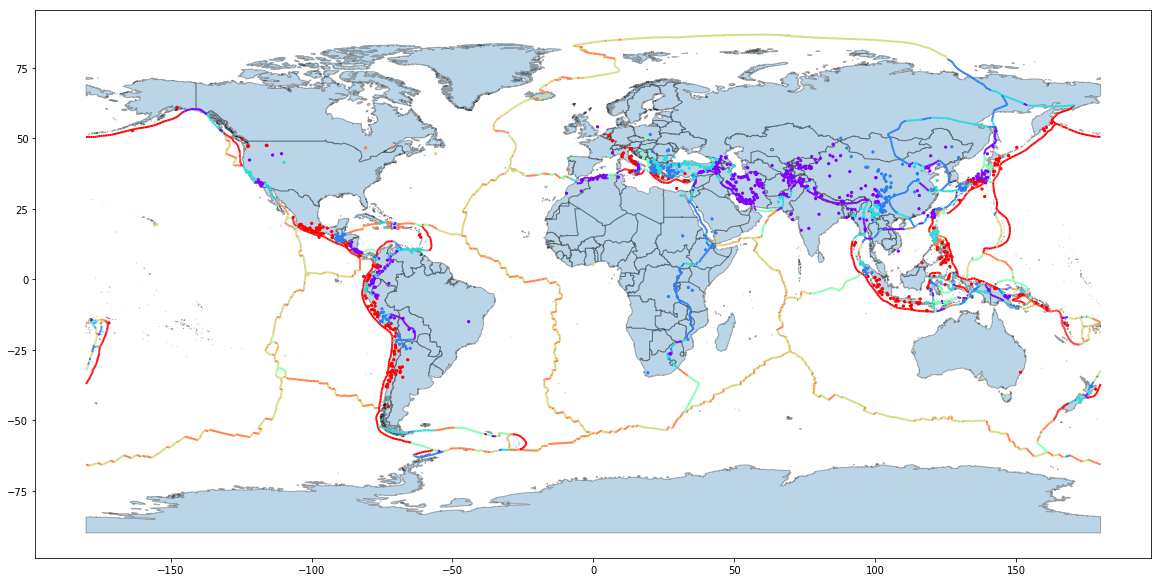

In [49]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
boundaries_gdf.plot(ax=ax, column='STEPCLASS', cmap='rainbow', lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

# all points (earthquakes, volcanoes, and vents)
boundary_distances_gdf.plot(ax=ax, column='closest_plate', cmap='rainbow', markersize=5)